In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings 
#import geopandas as gpd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
import statsmodels.api as sm


warnings.filterwarnings('ignore')

sns.set(style="ticks", rc={"axes.labelsize":10})

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 8
np.set_printoptions(4)

In [115]:
import scipy.interpolate
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess


---
# Geographic, climate trends and EUI demographics x <a id='res_alloc'></a>

Apply best methods at a high resolution to predict energy poverty indicators<br>

#### Import ACS data cleaned in the same way as the RECS sub dataset

In [116]:
path = '/global/scratch/users/cristina_crespo/p1_data/'
acs_data_raw = pd.read_csv(path +'out_final/ct_enhanced_fig_plotting_results.csv')


We first drop columns that are irrelevant with the normalized one-hot encoder modelling we have created. Notice that in this case we are using normalized proportions instead of binary coding for these variables (explained in the ACS_EDA.ipynb. We conserve the structure of the _subdataframefor RECS so that we can apply the models directly to these new observations.

In [117]:
#FILTER OUT ALASKA AND HAWAII
acs_data_raw = acs_data_raw[ ~acs_data_raw.state.isin([2, 15])]
acs_data_raw = acs_data_raw[(acs_data_raw.Race_majority !='Not Hispanic or Latino: American Indian and Alaska Native')  & (acs_data_raw.Race_majority !='Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander')]


In [118]:
len(acs_data_raw)

82142

In [128]:
palette = sns.color_palette("Set2")

econ_col = palette[2]
physical_col= 'lightgrey'
beh_col = palette[3]#'coral'

----

### Rurality and climate relationship with energy poverty 

In [120]:
# Define the indicators and corresponding x-axis variables for each row
row1_indicators = ['Energy Burden (%)']
row2_indicators = ['SCALEB_odds', 'SCALEG_odds', 'SCALEE_odds']
row3_indicators = ['HEAT_EUI_pred', 'COOL_EUI_pred']

acs_data_raw['perc_RURAL'] = 100*acs_data_raw['frac_RURAL']
acs_data_raw['perc_CDD']= 100*acs_data_raw['CDD']/acs_data_raw['CDD'].max()
x_vars = ['perc_CDD', 'perc_RURAL']  # Keep only the first and third columns
row_colors = [
    [econ_col],  # Row 1: One color for one trend line
    [beh_col, beh_col, 'grey'],  # Row 2: Three colors for three trend lines
    ['grey', 'grey']  # Row 3: Two colors for two trend lines
]

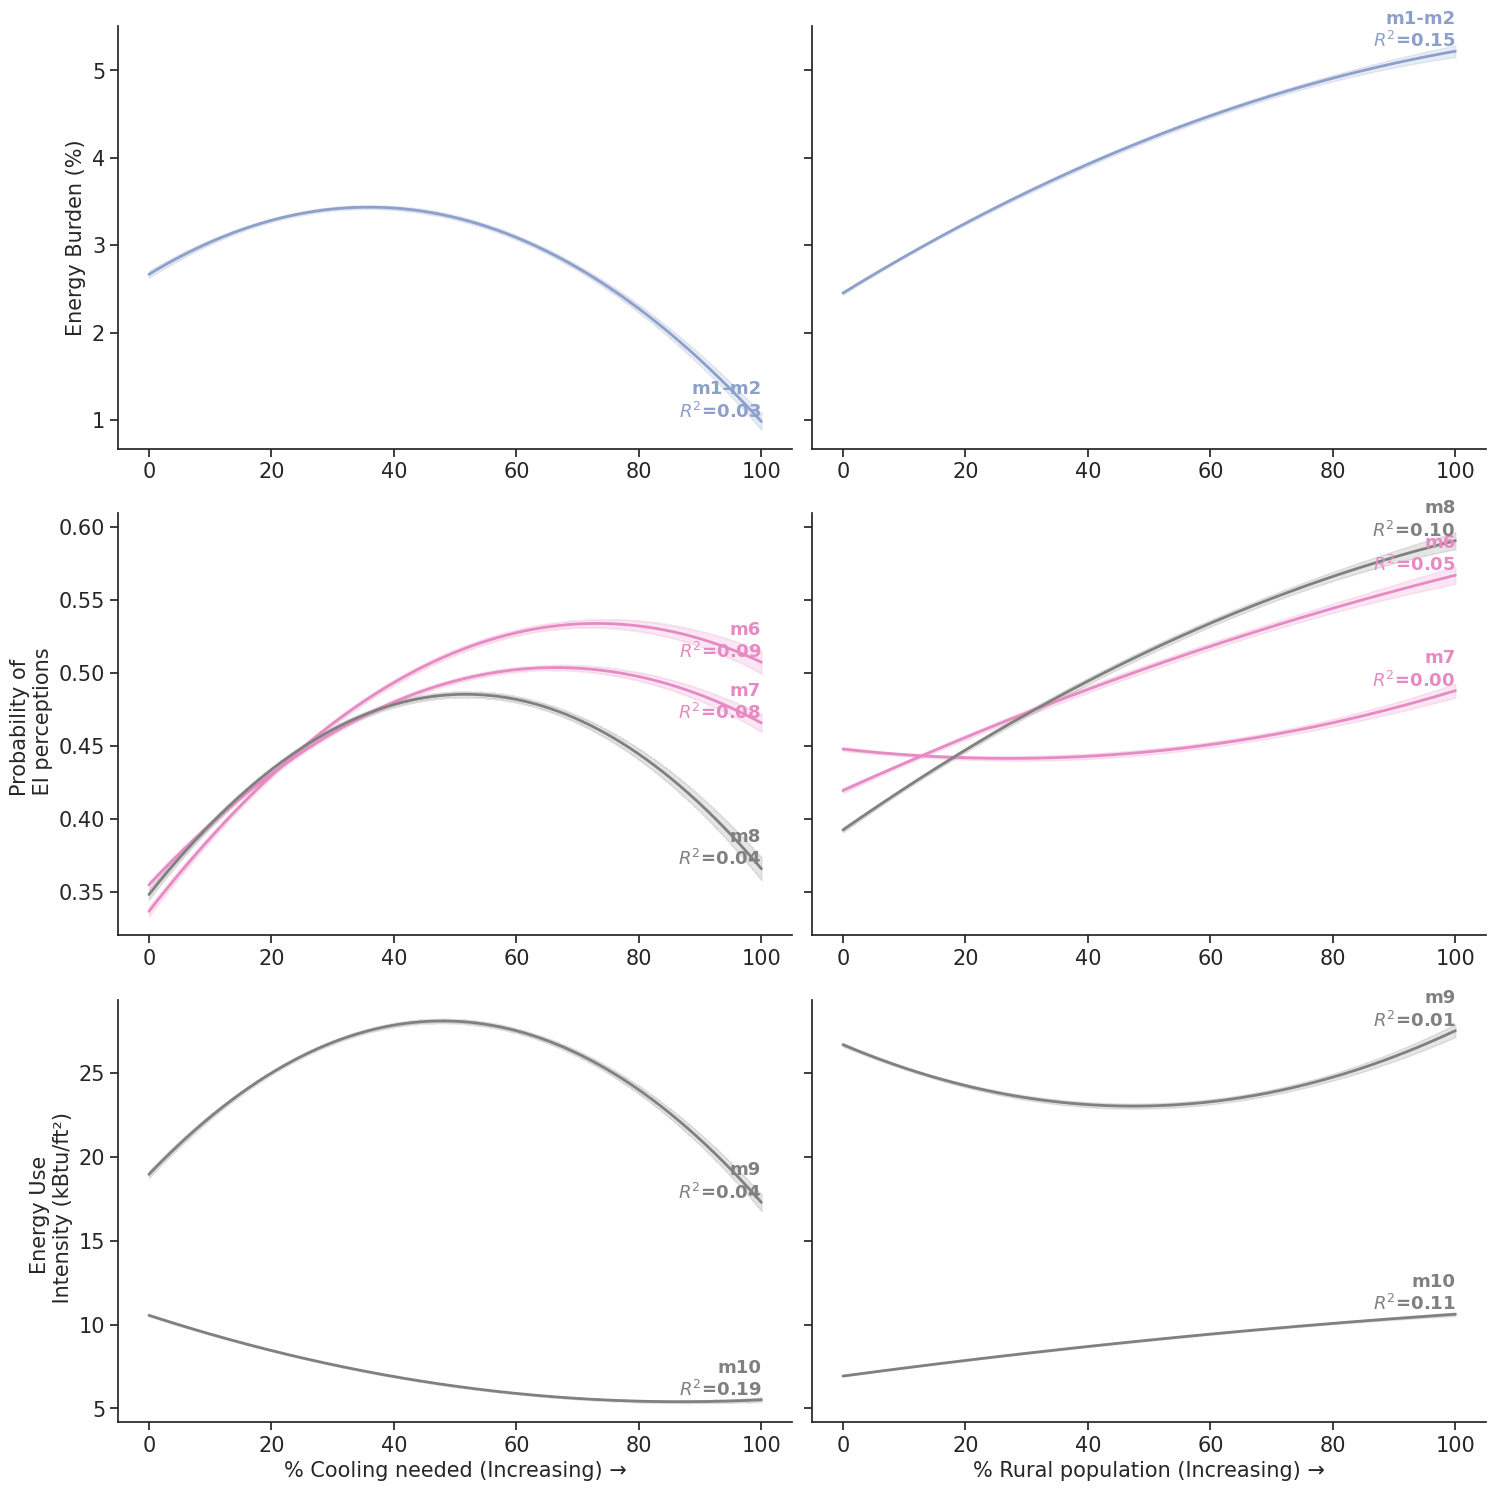

In [121]:
def plot_quadratic_fit_with_r2(ax, x, y, color, label, annotation):
    x_sorted = np.sort(x)
    y_sorted = y[np.argsort(x)]
    poly_coeffs = np.polyfit(x_sorted, y_sorted, 2)
    y_fit = np.polyval(poly_coeffs, x_sorted)

    x_matrix = np.vstack([x_sorted**2, x_sorted, np.ones_like(x_sorted)]).T
    model = sm.OLS(y_sorted, x_matrix).fit()
    predictions = model.get_prediction(x_matrix)
    ci_lower, ci_upper = predictions.conf_int()[:, 0], predictions.conf_int()[:, 1]
    r2 = model.rsquared

    ax.plot(x_sorted, y_fit, color=color, label=label, linewidth=2)
    ax.fill_between(x_sorted, ci_lower, ci_upper, color=color, alpha=0.2)

    text = f"{annotation}\n$R^2$={r2:.2f}"
    ax.text(x_sorted[-1], y_fit[-1], text, fontsize=13, color=color,
            verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

# ---- FIGURE 1: TREND LINES WITH CONFIDENCE INTERVALS + R2 ----
fig1, axes1 = plt.subplots(3, 2, sharey='row', figsize=(15, 15))
fs = 15

annotation_labels = ['m1-m2', 'm1-m2', 'm6', 'm7', 'm8', 'm6', 'm7', 'm8', 'm9', 'm10', 'm9', 'm10']
annotation_idx = 0

for col, x_var in enumerate(x_vars):
    x_data = acs_data_raw[x_var].dropna().values
    y_data = acs_data_raw.loc[acs_data_raw[x_var].notna(), row1_indicators[0]].values
    plot_quadratic_fit_with_r2(axes1[0, col], x_data, y_data, row_colors[0][0], row1_indicators[0], annotation_labels[annotation_idx])
    annotation_idx += 1

for col, x_var in enumerate(x_vars):
    for i, (ind, color) in enumerate(zip(row2_indicators, row_colors[1])):
        x_data = acs_data_raw[x_var].dropna().values
        y_data = acs_data_raw.loc[acs_data_raw[x_var].notna(), ind].values
        plot_quadratic_fit_with_r2(axes1[1, col], x_data, y_data, color, ind, annotation_labels[annotation_idx])
        annotation_idx += 1

for col, x_var in enumerate(x_vars):
    for i, (ind, color) in enumerate(zip(row3_indicators, row_colors[2])):
        x_data = acs_data_raw[x_var].dropna().values
        y_data = acs_data_raw.loc[acs_data_raw[x_var].notna(), ind].values
        plot_quadratic_fit_with_r2(axes1[2, col], x_data, y_data, color, ind, annotation_labels[annotation_idx])
        annotation_idx += 1

axes1[0, 0].set_ylabel("Energy Burden (%)", fontsize=fs)
axes1[1, 0].set_ylabel("Probability of \n EI perceptions", fontsize=fs)
axes1[2, 0].set_ylabel("Energy Use \n Intensity (kBtu/ft²)", fontsize=fs)
axes1[2, 0].set_xlabel("% Cooling needed (Increasing) →", fontsize=fs)
axes1[2, 1].set_xlabel("% Rural population (Increasing) →", fontsize=fs)

for ax in axes1.flat:
    ax.tick_params(labelsize=fs)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(ScalarFormatter())

fig1.tight_layout()
sns.despine(fig=fig1)
#fig.savefig("ei_rural_cooling_trends.pdf", format="pdf", bbox_inches="tight")

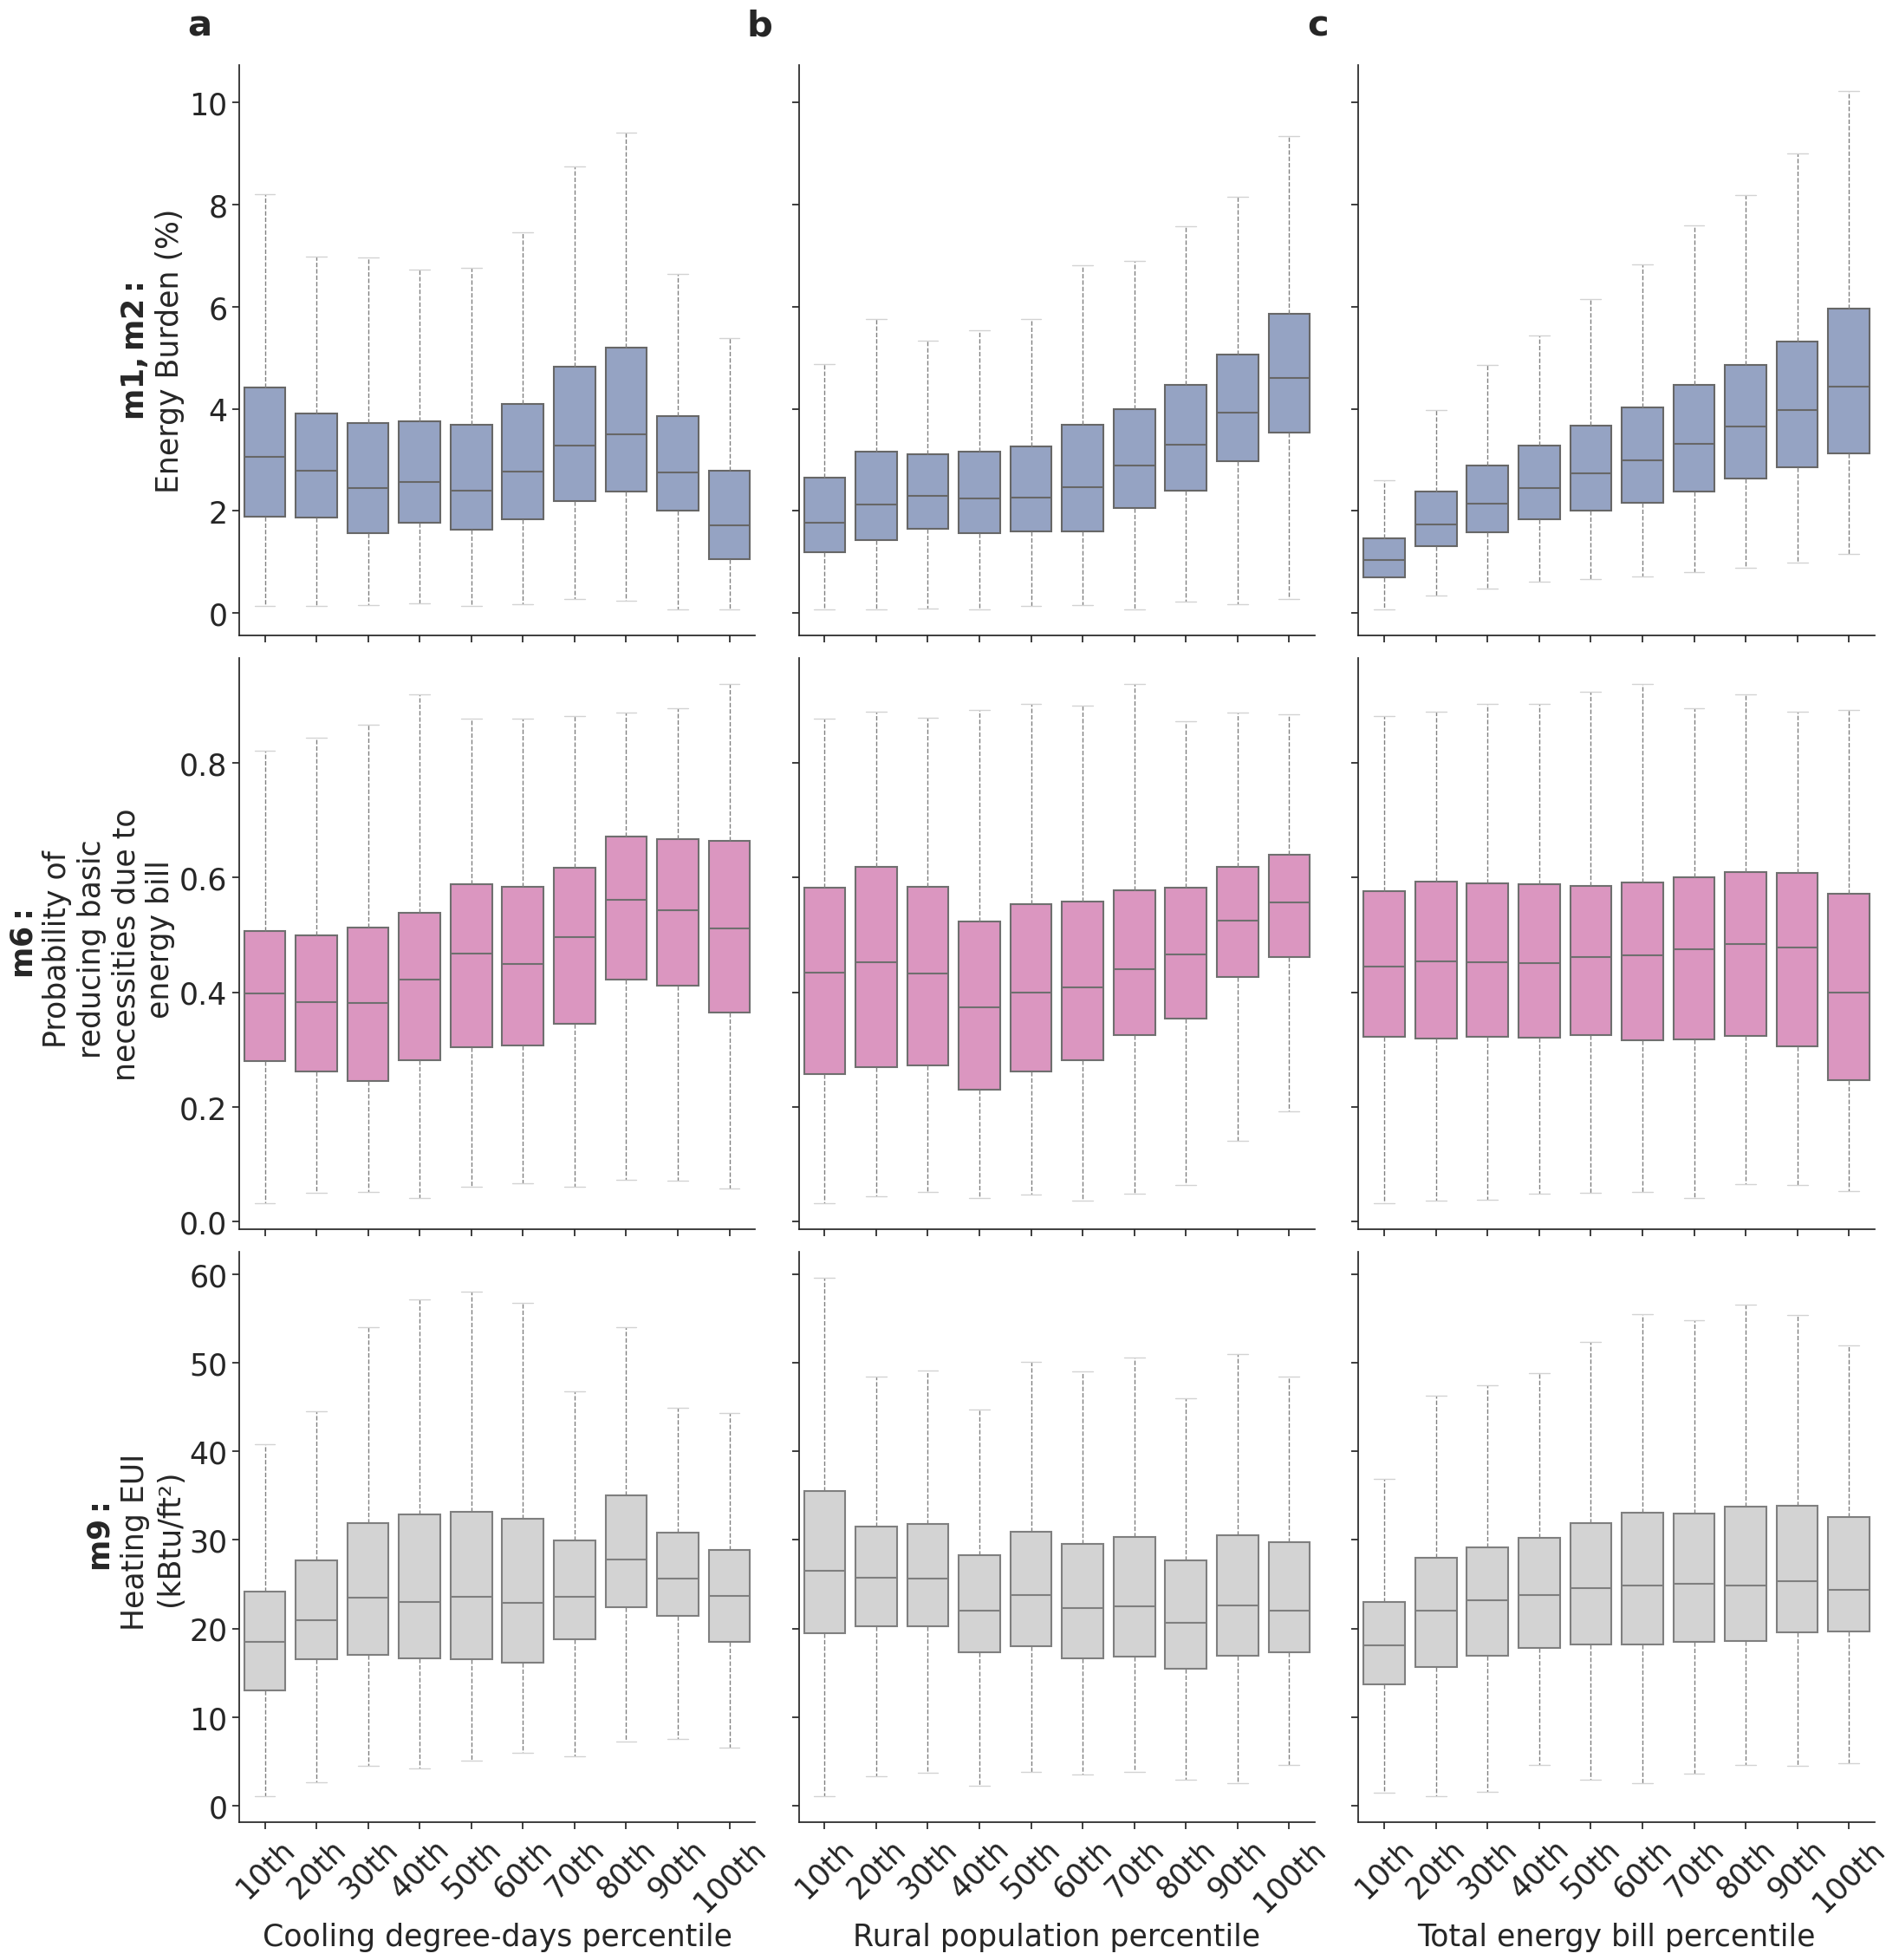

In [122]:
# === SETTINGS ===
fig1, axes1 = plt.subplots(3, 3, figsize=(22, 22), sharex=False, sharey='row')
fs = 25
n_bins = 10

# === INDICATORS & COLORS ===
indicators = ['Energy Burden (%)','SCALEB_odds', 'HEAT_EUI_pred']

colors = [econ_col, beh_col, 'lightgrey']

# === X-axis variable names ===
x_vars = ['perc_CDD', 'perc_RURAL', 'bill_TOTAL']

# === Custom boxplot style ===
boxplot_kwargs = dict(
    showfliers=False,
    whiskerprops=dict(linestyle='dashed', linewidth=1, color='grey'),
    capprops=dict(color='lightgrey', linewidth=1.0),
    flierprops=dict(markerfacecolor='grey', marker='+')
)

# === PLOTTING ===
percentile_labels = [f"{p}th" for p in range(10, 110, 10)]

for i, (indicator, color) in enumerate(zip(indicators, colors)):
    for j, x_var in enumerate(x_vars):
        ax = axes1[i, j]
        x_data = acs_data_raw[x_var]
        y_data = acs_data_raw[indicator]

        # Drop NA
        mask = ~x_data.isna() & ~y_data.isna()
        x_data = x_data[mask]
        y_data = y_data[mask]

        # Bin x into quantiles (10 bins)
        bins = pd.qcut(x_data, n_bins, labels=False, duplicates='drop')

        # Plot boxplot
        sns.boxplot(
            x=bins,
            y=y_data,
            ax=ax,
            color=color,
            **boxplot_kwargs
        )

        # Formatting
        ax.tick_params(labelsize=fs)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())

        # Hide y-label if not in first column
        if j > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel(indicator, fontsize=fs)

        # Handle x-axis tick labels
        if i < 2:
            ax.set_xticklabels([])
            ax.set_xlabel("")
        else:
            ax.set_xticklabels(percentile_labels, fontsize=fs)
            ax.set_xlabel(["Cooling degree-days percentile", "Rural population percentile", "Total energy bill percentile"][j], fontsize=fs)
            ax.tick_params(axis='x', labelrotation=45)
# === Y-axis labels ===
axes1[0, 0].set_ylabel(r"$\mathbf{m1, m2:}$" + "\nEnergy Burden (%)", fontsize=fs)
axes1[1, 0].set_ylabel(r"$\mathbf{m6:}$" + "\nProbability of \nreducing basic \n necessities due to \n energy bill", fontsize=fs)
axes1[2, 0].set_ylabel(r"$\mathbf{m9:}$" + "\nHeating EUI \n(kBtu/ft²)", fontsize=fs)

axes1[2, 0].set_xlabel("Cooling degree-days percentile", fontsize=fs)
axes1[2, 1].set_xlabel("Rural population percentile", fontsize=fs)
axes1[2, 2].set_xlabel("Total energy bill percentile", fontsize=fs)

# === FINAL LAYOUT ===
fig1.tight_layout()
sns.despine(fig=fig1)

# "Reducing basic necessities \n due to energy bill", 
#"Keeping home at \n unhealthy temperature",
#"Receiving disconnection \n notice", "2M Heating EUI", "2M Cooling EUI"

axes1[0, 0].text(-0.1, 1.1, 'a', transform=axes1[0, 0].transAxes, fontsize=30, fontweight='bold', va='top', ha='left')
axes1[0, 1].text(-0.1, 1.1, 'b', transform=axes1[0, 1].transAxes, fontsize=30, fontweight='bold', va='top', ha='left')
axes1[0, 2].text(-0.1, 1.1, 'c', transform=axes1[0, 2].transAxes, fontsize=30, fontweight='bold', va='top', ha='left')

fig1.savefig("ei_rural_cooling_costs_trends.pdf", format="pdf", bbox_inches="tight")

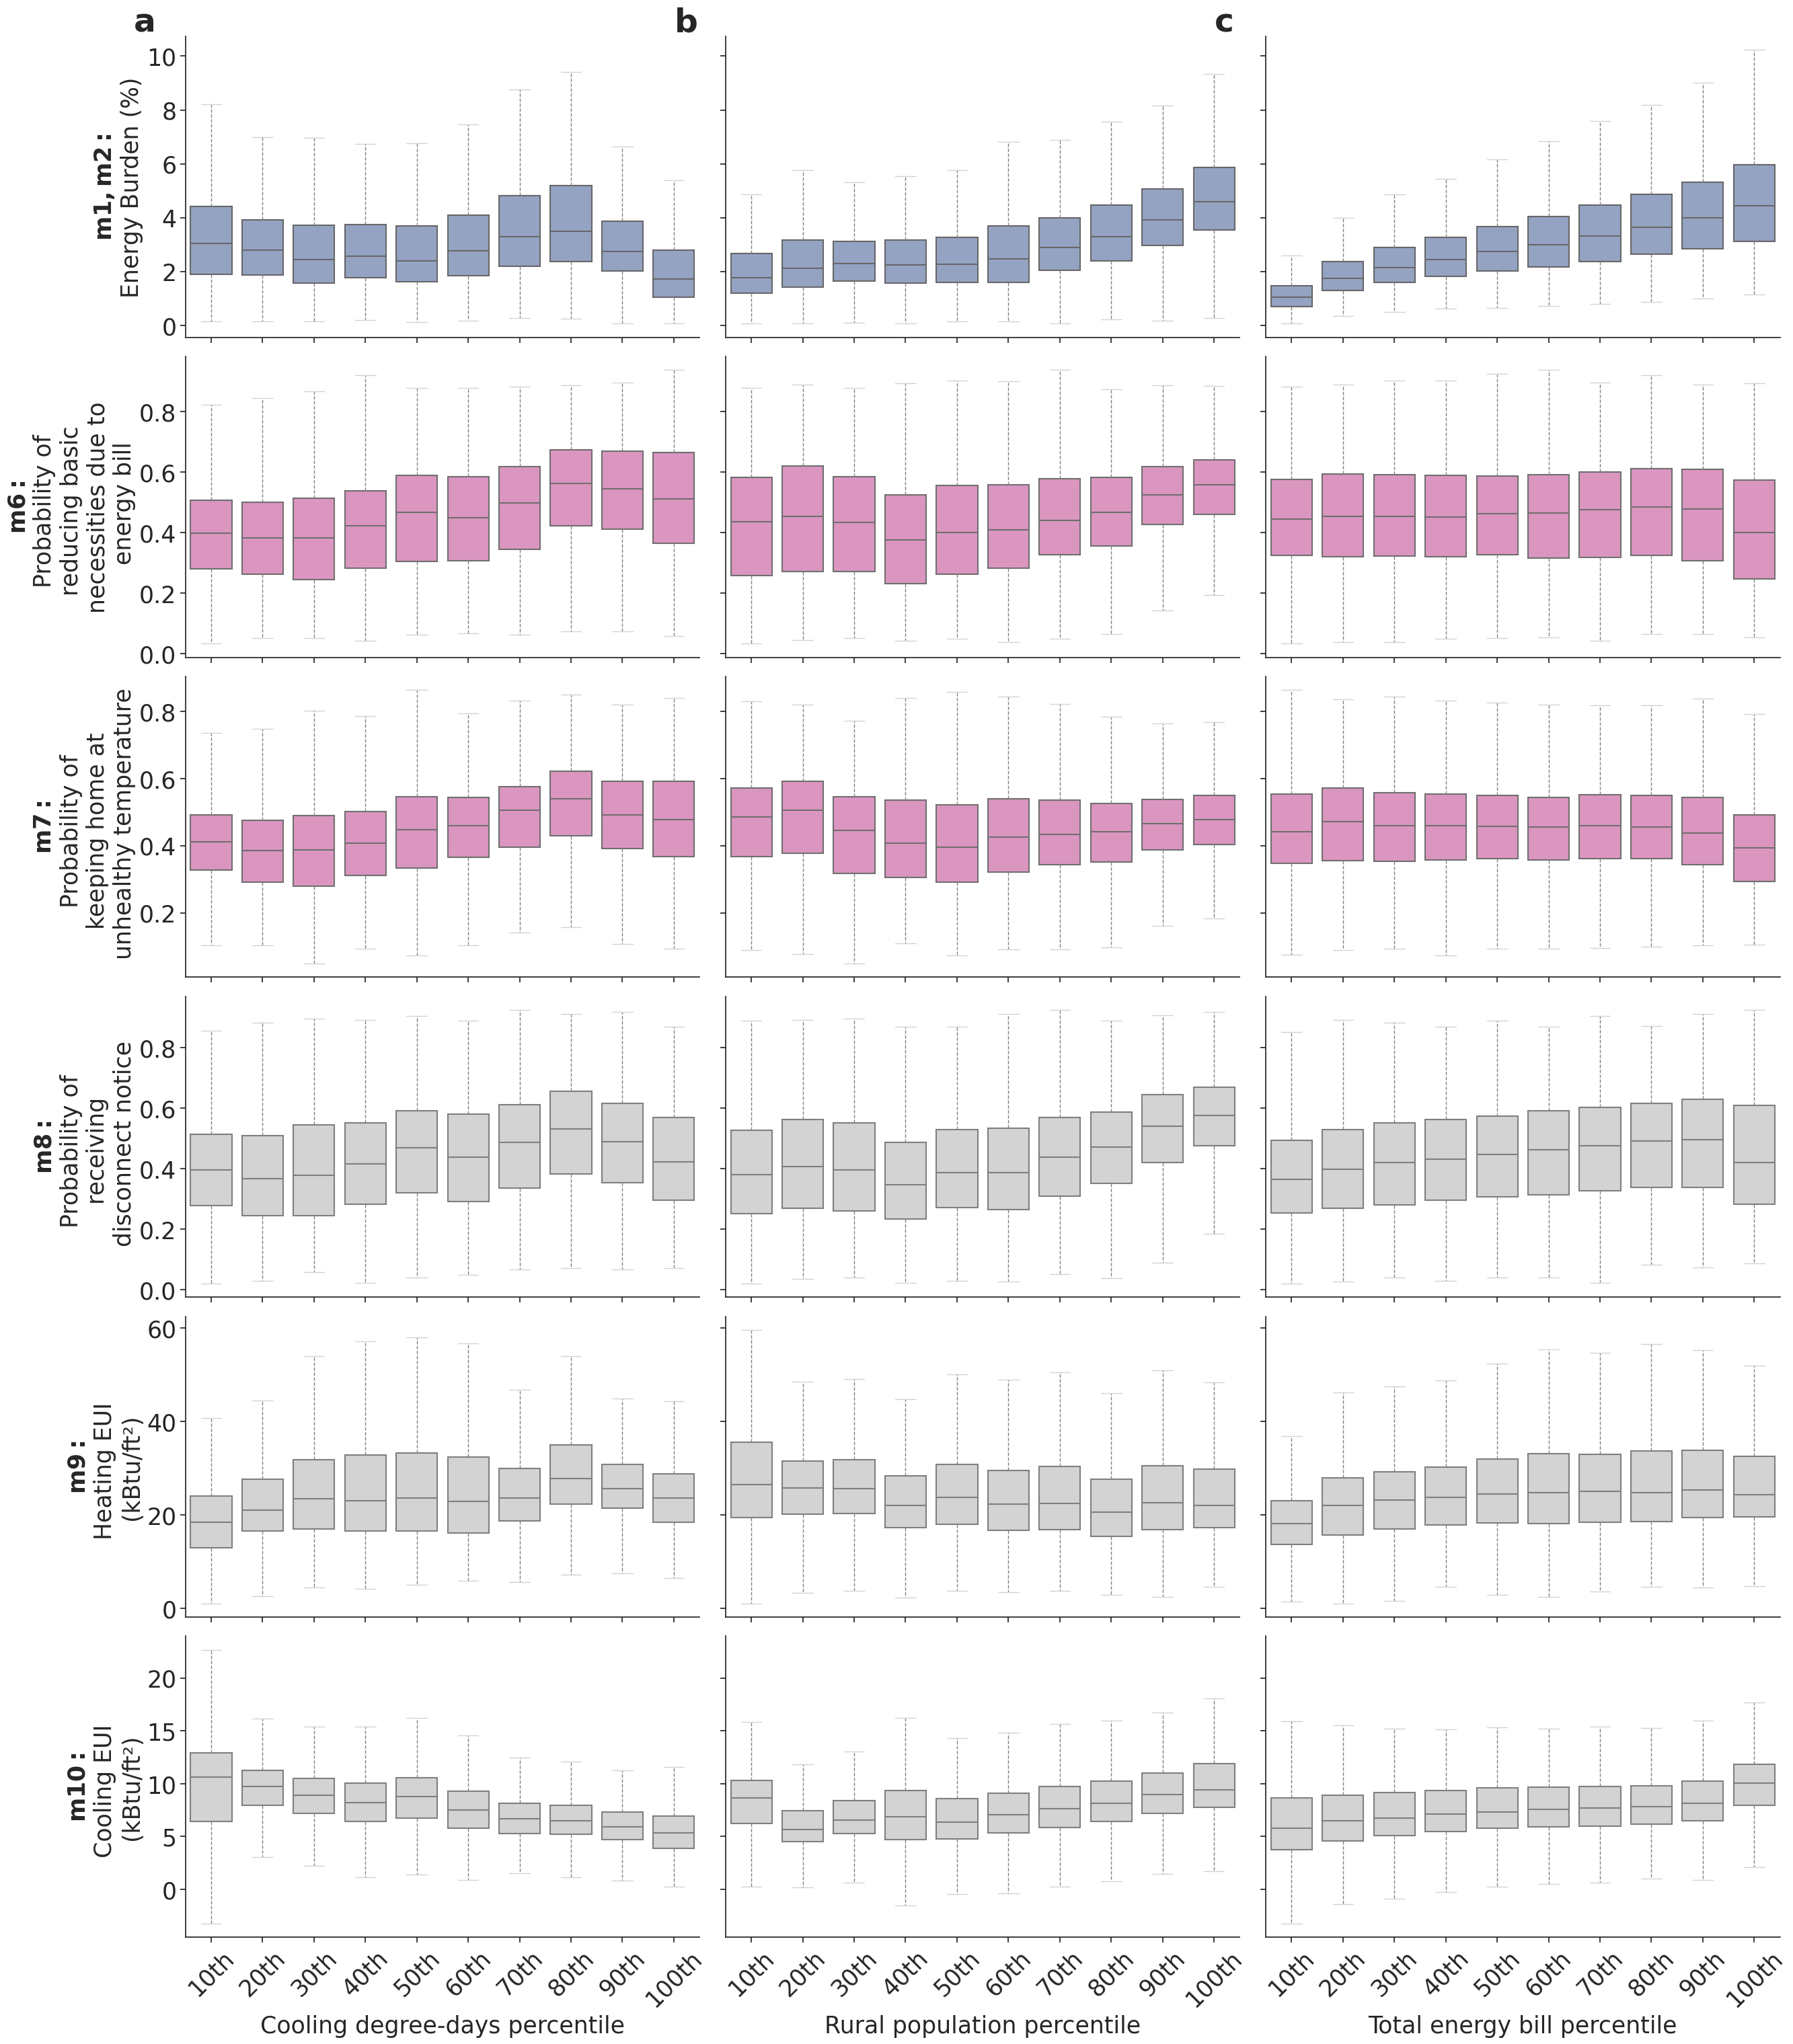

In [93]:
# === SETTINGS ===
fig1, axes1 = plt.subplots(6, 3, figsize=(27, 30), sharex=False, sharey='row')
fs = 25
n_bins = 10

# === INDICATORS & COLORS ===
indicators = ['Energy Burden (%)','SCALEB_odds', 'SCALEG_odds', 
              'SCALEE_odds','HEAT_EUI_pred', 'COOL_EUI_pred']

colors = [econ_col, beh_col, beh_col, 'lightgrey', 'lightgrey', 'lightgrey' ]

# === X-axis variable names ===
x_vars = ['perc_CDD', 'perc_RURAL', 'bill_TOTAL']

# === Custom boxplot style ===
boxplot_kwargs = dict(
    showfliers=False,
    whiskerprops=dict(linestyle='dashed', linewidth=1, color='grey'),
    capprops=dict(color='lightgrey', linewidth=1.0),
    flierprops=dict(markerfacecolor='grey', marker='+')
)

# === PLOTTING ===
percentile_labels = [f"{p}th" for p in range(10, 110, 10)]

for i, (indicator, color) in enumerate(zip(indicators, colors)):
    for j, x_var in enumerate(x_vars):
        ax = axes1[i, j]
        x_data = acs_data_raw[x_var]
        y_data = acs_data_raw[indicator]

        # Drop NA
        mask = ~x_data.isna() & ~y_data.isna()
        x_data = x_data[mask]
        y_data = y_data[mask]

        # Bin x into quantiles (10 bins)
        bins = pd.qcut(x_data, n_bins, labels=False, duplicates='drop')

        # Plot boxplot
        sns.boxplot(
            x=bins,
            y=y_data,
            ax=ax,
            color=color,
            **boxplot_kwargs
        )

        # Formatting
        ax.tick_params(labelsize=fs)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())

        # Hide y-label if not in first column
        if j > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel(indicator, fontsize=fs)

        # Handle x-axis tick labels
        if i < 5:
            ax.set_xticklabels([])
            ax.set_xlabel("")
        else:
            ax.set_xticklabels(percentile_labels, fontsize=fs)
            ax.set_xlabel(["Cooling degree-days percentile", "Rural population percentile", "Total energy bill percentile"][j], fontsize=fs)
            ax.tick_params(axis='x', labelrotation=45)
# === Y-axis labels ===
axes1[0, 0].set_ylabel(r"$\mathbf{m1, m2:}$" + "\nEnergy Burden (%)", fontsize=fs)
axes1[1, 0].set_ylabel(r"$\mathbf{m6:}$" + "\nProbability of \nreducing basic \n necessities due to \n energy bill", fontsize=fs)
axes1[2, 0].set_ylabel(r"$\mathbf{m7:}$" + "\nProbability of \nkeeping home at \n unhealthy temperature", fontsize=fs)
axes1[3, 0].set_ylabel(r"$\mathbf{m8:}$" + "\nProbability of \nreceiving \n disconnect notice", fontsize=fs)
axes1[4, 0].set_ylabel(r"$\mathbf{m9:}$" + "\nHeating EUI \n(kBtu/ft²)", fontsize=fs)
axes1[5, 0].set_ylabel(r"$\mathbf{m10:}$" + "\nCooling EUI \n(kBtu/ft²)", fontsize=fs)

# === FINAL LAYOUT ===
fig1.tight_layout()
sns.despine(fig=fig1)

# Subfigure labels
axes1[0, 0].text(-0.1, 1.1, 'a', transform=axes1[0, 0].transAxes, fontsize=35, fontweight='bold', va='top', ha='left')
axes1[0, 1].text(-0.1, 1.1, 'b', transform=axes1[0, 1].transAxes, fontsize=35, fontweight='bold', va='top', ha='left')
axes1[0, 2].text(-0.1, 1.1, 'c', transform=axes1[0, 2].transAxes, fontsize=35, fontweight='bold', va='top', ha='left')

fig1.savefig("SI_all_ei_rural_cooling_costs_trends.pdf", format="pdf", bbox_inches="tight")

In [ ]:
fig.savefig("ei_rural_cooling_trends_lowess.pdf", format="pdf", bbox_inches="tight")

## Plot EUI-demographic relationships

Establish palette

In [129]:
#race
#palette_race ={ "Not Hispanic or Latino: Asian alone": '#80649e', 
               #"No majority": '#939aba',
              # "Not Hispanic or Latino: Black or African American": '#a9d0d6',
              # "Hispanic or Latino":'#baeae4',  
              # "Not Hispanic or Latino: White": '#e2fff2'}
#palette_race ={ "Not Hispanic or Latino: Asian alone": '#fdb462',  "No majority": '#fb8072',"Not Hispanic or Latino: Black or African American": '#80b1d3',"Hispanic or Latino":'#8dd3c7',  "Not Hispanic or Latino: White": '#bebada'}
#cmap_race =["#80649e","#939aba","#a9d0d6","#baeae4","#e2fff2"]
#'#fdb462', '#fb8072','#80b1d3', '#8dd3c7', '#bebada' ] #"Not Hispanic or Latino: Black or African American", "Not Hispanic or Latino: White" ,  "No majority","Hispanic or Latino"  ,"Not Hispanic or Latino: Asian alone",  
#order_race = ["Not Hispanic or Latino: Asian alone","No majority",  "Not Hispanic or Latino: Black or African American", "Hispanic or Latino", "Not Hispanic or Latino: White"]

#race
palette_race ={ "Not Hispanic or Latino: Asian alone": 'lightpink', 
               "No majority": 'lightgrey',
               "Not Hispanic or Latino: Black or African American": palette[0],
               "Hispanic or Latino":'#baeae4',  
               "Not Hispanic or Latino: White": '#80649e'}
order_race = [ "Not Hispanic or Latino: White", "No majority",  "Hispanic or Latino", "Not Hispanic or Latino: Black or African American","Not Hispanic or Latino: Asian alone"]
cmap_race =["#80649e","lightgrey","#baeae4",palette[0],"lightpink"]


#gender
male = '#939aba' #'#67d0bd'
female = '#a9d0d6'#'#b66fcd'
palette_gender ={'Female':female, 'Male': male}#{'Female':'lightblue', 'Male': 'darkblue'}
order_gender =['Female', 'Male']
cmap_gender=[female, male]



###### Lowess plot sources

https://james-brennan.github.io/posts/lowess_conf/

SE for condidence interval of mean
https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#conf_int_of_mean

#### Level indicators per demographic and INCOME

In [123]:
acs_data_raw['Total fuel usage (kWh)'] = 1000*(acs_data_raw['BTUOF_pred']+
                                               acs_data_raw['BTUNG_pred']+
                                               acs_data_raw['BTUEL_pred'])*0.000293071
acs_data_raw.rename(columns= {'HEAT_EUI_pred':'Heating Energy Use Intensity (kBtu/ft2)',
                              'COOL_EUI_pred':'Cooling Energy Use Intensity (kBtu/ft2)'}, inplace = True)

Totals

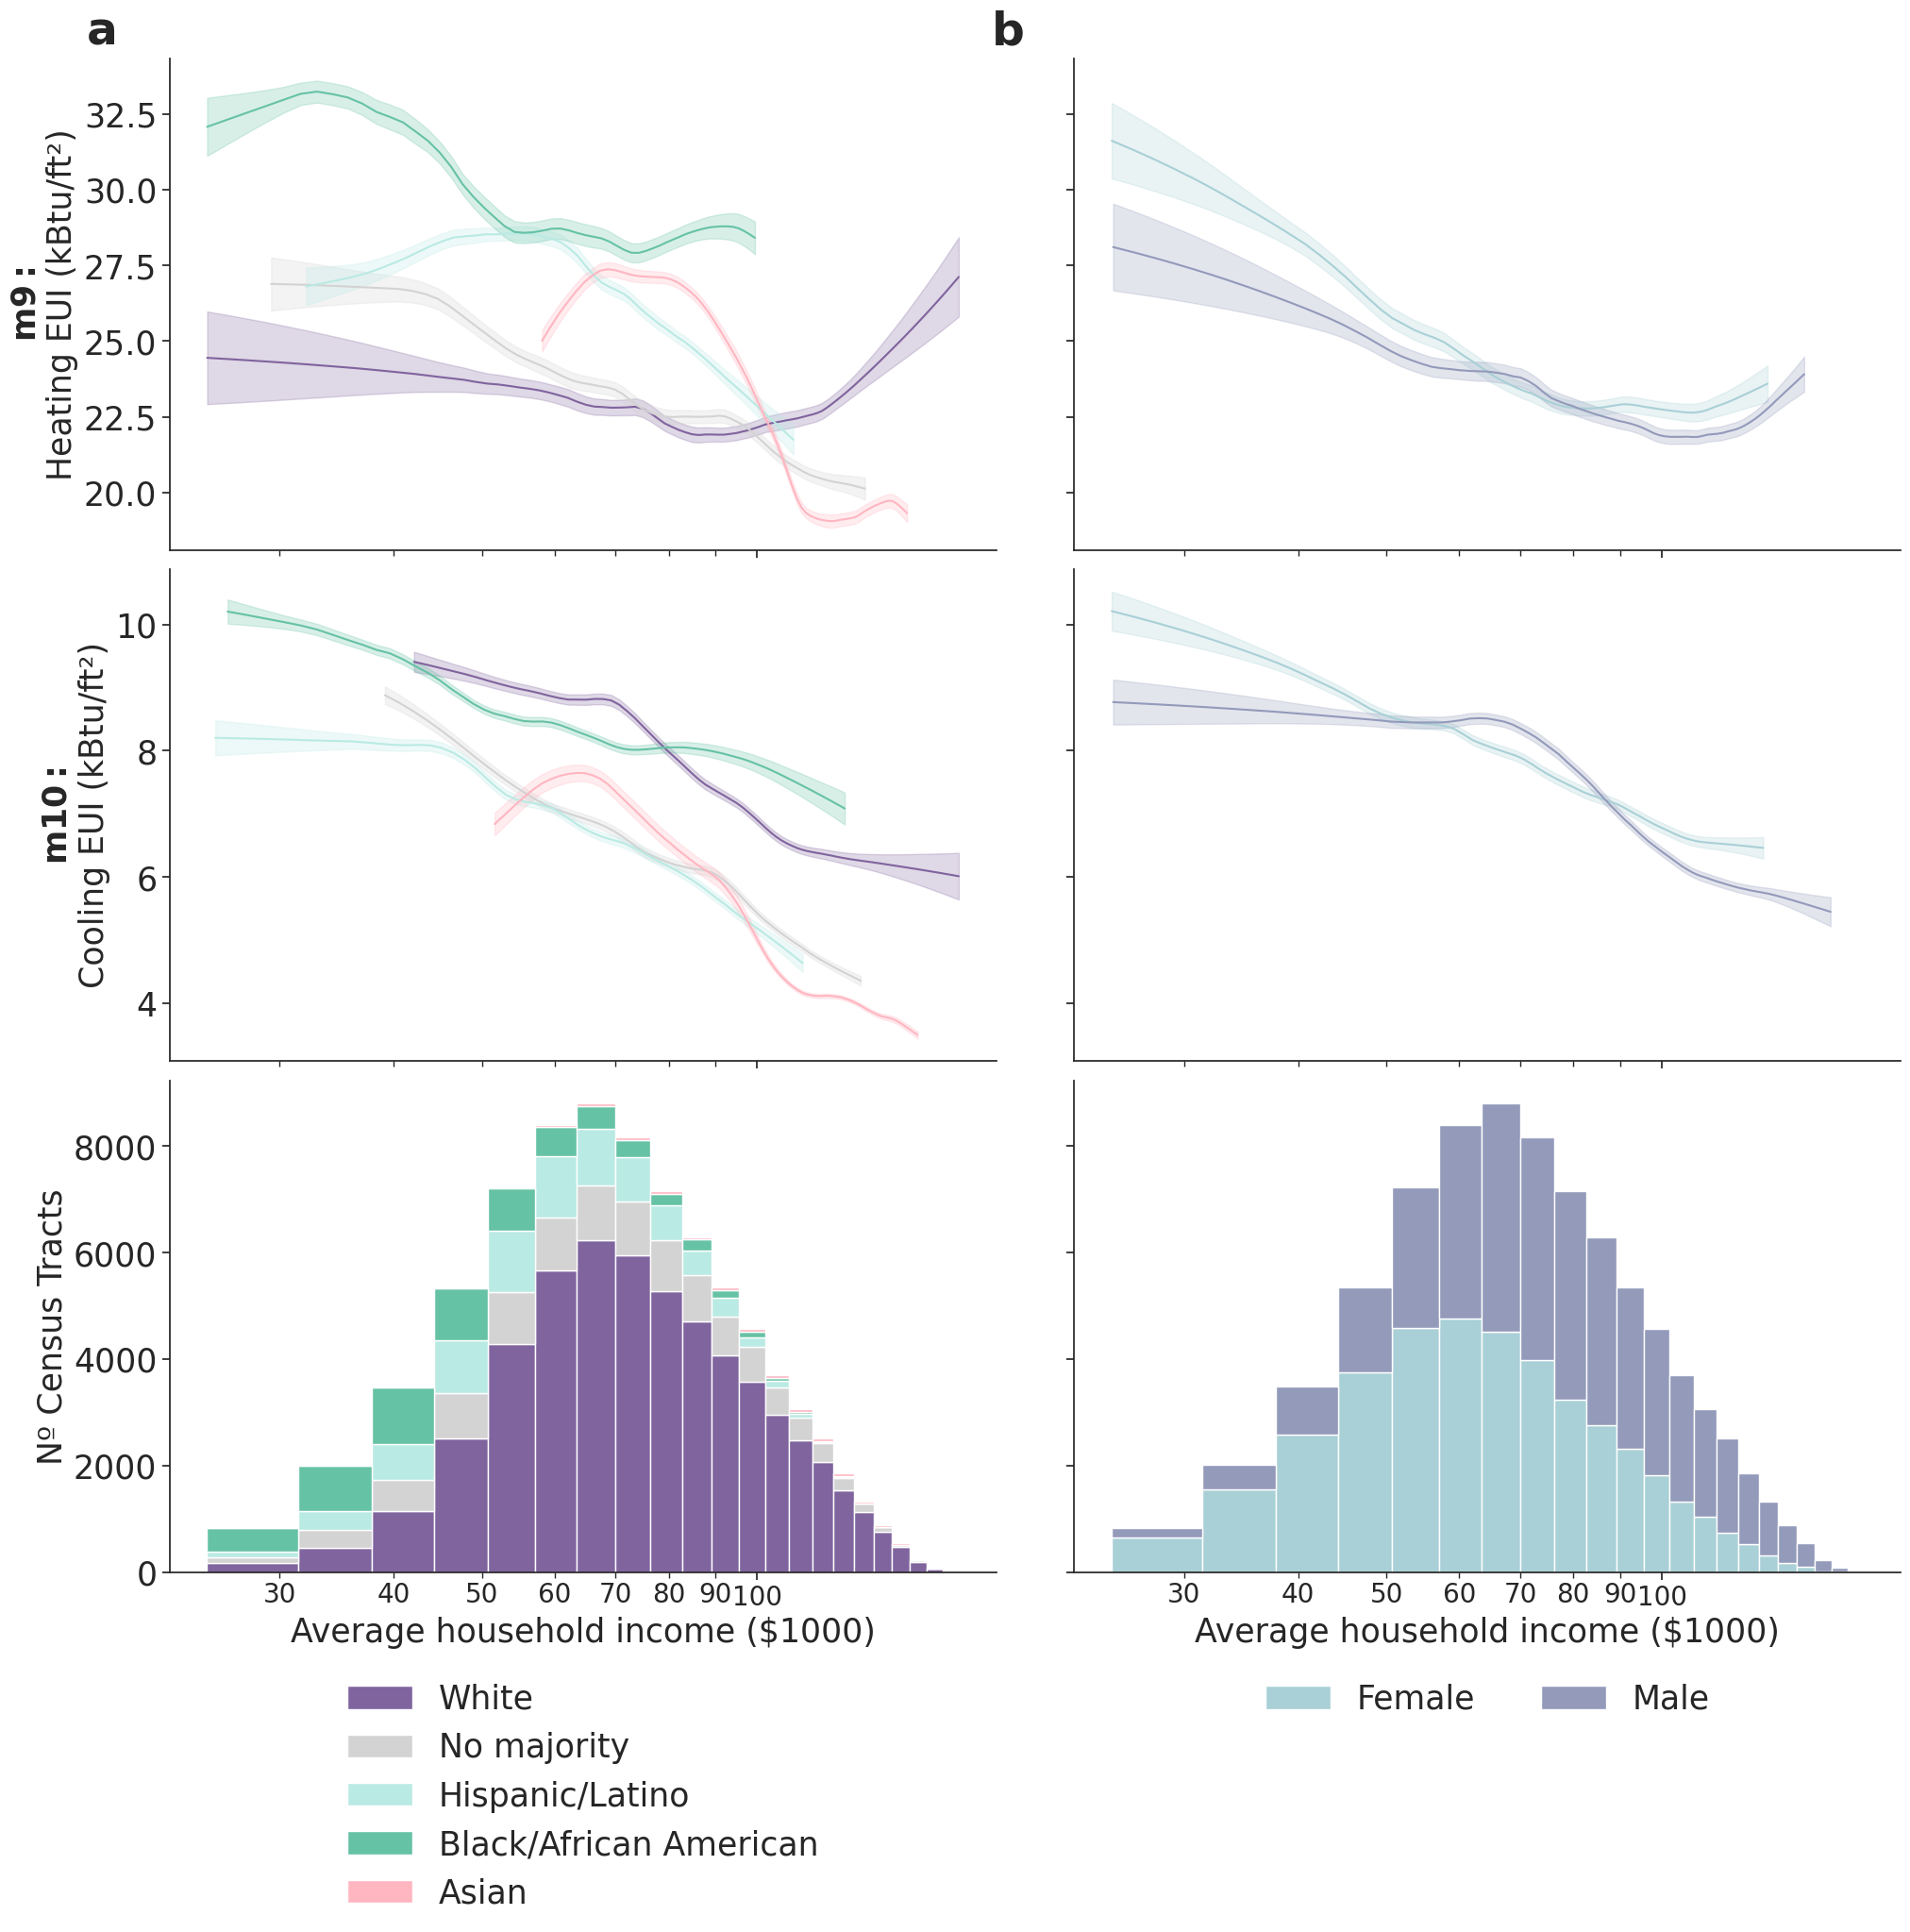

In [37]:
# Simplified race label mapping
race_label_map = {
    "Not Hispanic or Latino: White": "White",
    "No majority": "No majority",
    "Hispanic or Latino": "Hispanic/Latino",
    "Not Hispanic or Latino: Black or African American": "Black/African American",
    "Not Hispanic or Latino: Asian alone": "Asian"
}

# === Settings ===
fig, axes = plt.subplots(nrows=3, ncols=2, sharey='row', sharex=True, figsize=(20, 20))
fig.subplots_adjust(hspace=0.7)

x_variable = 'Average household income'
x_variable_new = 'Average household income_new'
acs_data_raw[x_variable_new] = acs_data_raw[x_variable].div(1000)
acs_data_raw_plot = acs_data_raw[(acs_data_raw[x_variable_new] > 25) & (acs_data_raw[x_variable_new] < 250)]

quant_indicators = [
    'Heating Energy Use Intensity (kBtu/ft2)',
    'Cooling Energy Use Intensity (kBtu/ft2)'
]
demos = ['Race_majority', 'Householder_binary']
orders = [order_race, order_gender]
palettes = [palette_race, palette_gender]
cmaps = [cmap_race, cmap_gender]
fs = 25
fs_title = 30
K = 300

# === Smoothing Function ===
def smooth(x, y, xgrid, fraction, n_samples):
    samples = np.random.choice(len(x), n_samples, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s, x_s, frac=fraction, it=3, return_sorted=False)
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, fill_value='extrapolate')(xgrid)
    return y_grid

# === Plotting ===
for i, ax in enumerate(axes.flat):
    if i == 4 or i == 5:
        demo = demos[i - 4]
        cmap = cmaps[i - 4]
        order = orders[i - 4]
        palette = palettes[i - 4]

        df_pivot = acs_data_raw_plot[[x_variable_new, demo]].pivot(columns=demo, values=x_variable_new)
        df_pivot = df_pivot[order]

        labels = [race_label_map.get(d, d) for d in order] if demo == "Race_majority" else order
        ax.hist(df_pivot, bins=22, histtype='bar', stacked=True,
                color=[palette[d] for d in order], label=labels)

        ax.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=1 if i == 4 else 2, borderaxespad=0., fontsize=fs, frameon=False)
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())
        ax.set_ylabel("Nº Census Tracts", fontsize=fs)
        ax.set_xlabel("Average household income ($1000)", fontsize=fs)
        continue

    # Determine which indicator/demographic
    if i == 0:
        demo, order, palette = demos[0], orders[0], palettes[0]
        indicator = quant_indicators[0]
        ax.text(-0.1, 1.1, 'a', transform=ax.transAxes, fontsize=35, fontweight='bold', va='top', ha='left')
    elif i == 1:
        demo, order, palette = demos[1], orders[1], palettes[1]
        indicator = quant_indicators[0]
        ax.set_ylabel("")  # No y-label on second column
        ax.text(-0.1, 1.1, 'b', transform=ax.transAxes, fontsize=35, fontweight='bold', va='top', ha='left')
    elif i == 2:
        demo, order, palette = demos[0], orders[0], palettes[0]
        indicator = quant_indicators[1]
    elif i == 3:
        demo, order, palette = demos[1], orders[1], palettes[1]
        indicator = quant_indicators[1]
        ax.set_ylabel("")  # No y-label on second column

    for d in order:
        x = acs_data_raw_plot[acs_data_raw_plot[demo] == d][x_variable_new].values
        y = acs_data_raw_plot[acs_data_raw_plot[demo] == d][indicator].values

        n_samples = 100
        xgrid = np.linspace(x.min(), x.max(), n_samples)
        fraction = 0.25

        smooths = np.stack([smooth(x, y, xgrid, fraction, n_samples) for _ in range(K)]).T
        mean = np.nanmean(smooths, axis=1)
        stderr = scipy.stats.sem(smooths, axis=1, ddof=0)

        nans_idx = np.isnan(stderr)
        mean = mean[~nans_idx]
        stderr = stderr[~nans_idx]
        xgrid = xgrid[~nans_idx]

        ax.fill_between(xgrid, mean - 1.96 * stderr, mean + 1.96 * stderr, alpha=0.25, color=palette[d])
        ax.plot(xgrid, mean, color=palette[d])

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(ScalarFormatter())

    # Increase tick font sizes
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)

# === Final Labels ===
axes[0, 0].set_ylabel(r"$\mathbf{m9:}$" + "\nHeating EUI (kBtu/ft²)", fontsize=fs)
axes[1, 0].set_ylabel(r"$\mathbf{m10:}$" + "\nCooling EUI (kBtu/ft²)", fontsize=fs)
axes[2, 1].set_ylabel("")

# === Apply Large Tick Font to Last Row ===
for ax in axes[2]:
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='x', which='minor', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=25)

plt.tight_layout()
sns.despine()

In [38]:
fig.savefig("eui_rel3.pdf", format="pdf", bbox_inches="tight")

#### Totals, for qualitative indicators

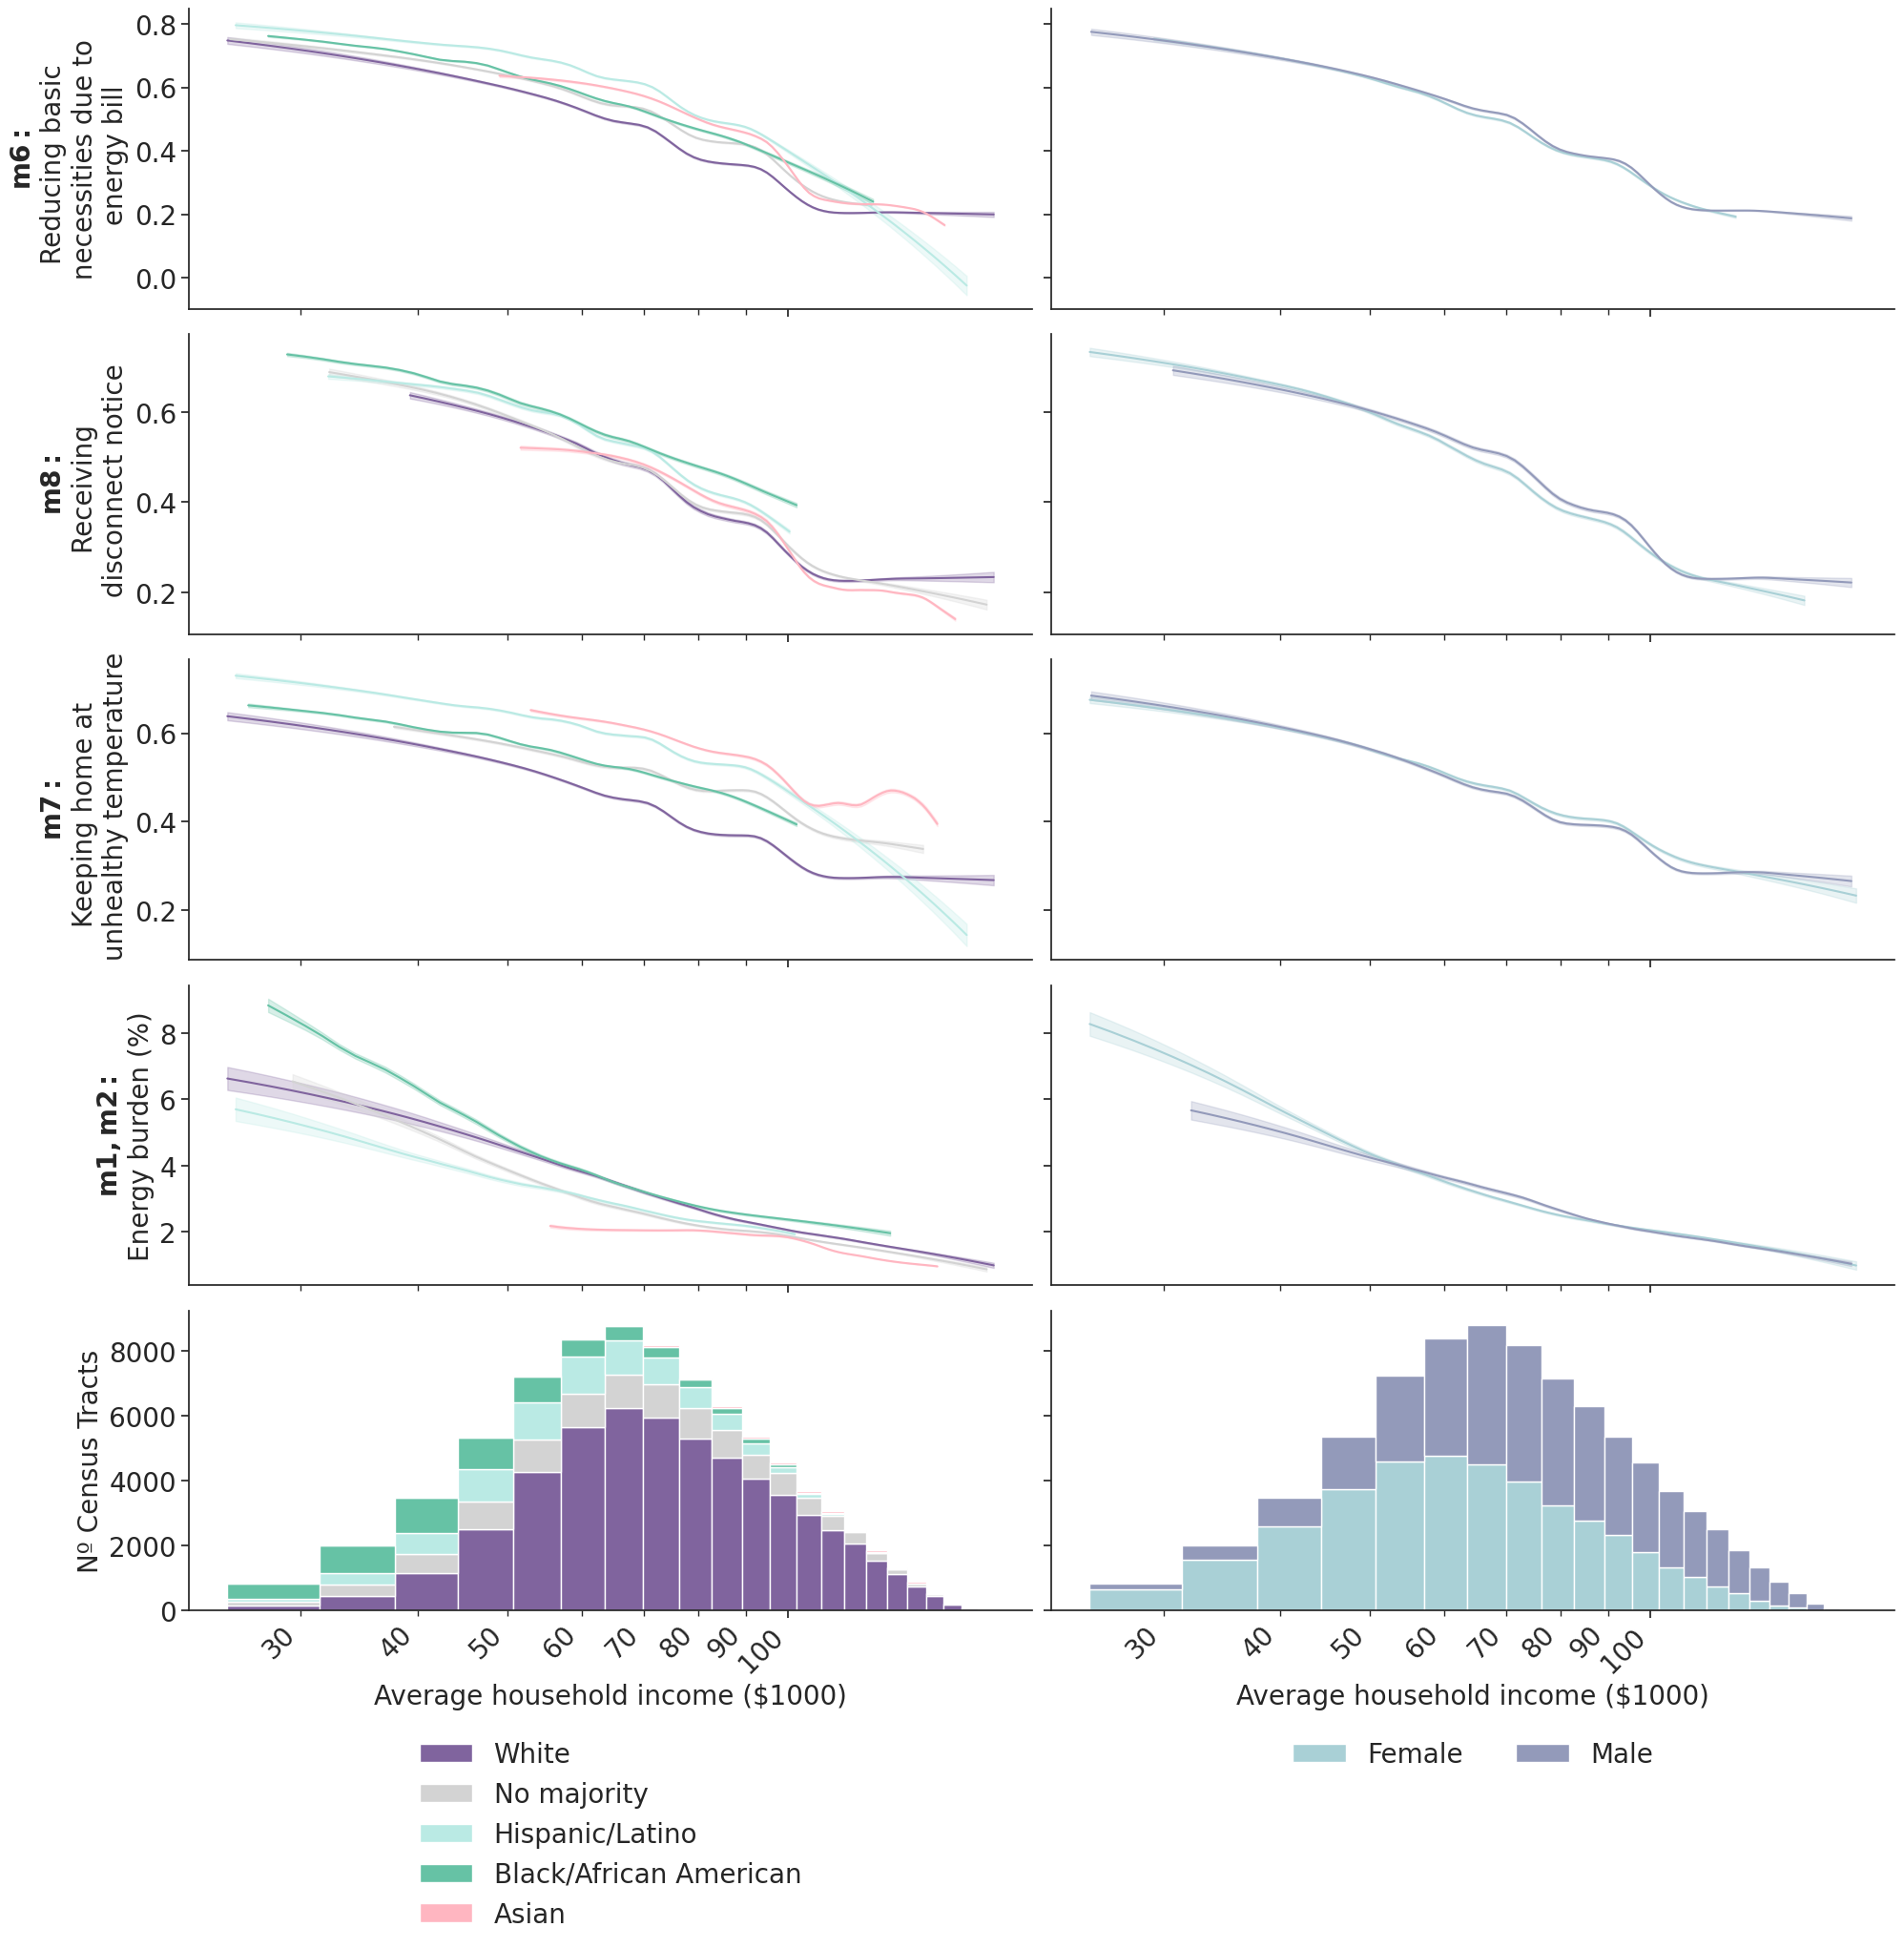

In [39]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharey='row', sharex=True, figsize=(20, 20))
fig.subplots_adjust(hspace=0.7)

x_variable = 'Average household income'
x_variable_new = 'Average household income_new'
acs_data_raw[x_variable_new] = acs_data_raw[x_variable].div(1000)
acs_data_raw_plot = acs_data_raw[(acs_data_raw[x_variable_new] > 25) & (acs_data_raw[x_variable_new] < 250)]

qual_indicators = ['SCALEB_odds', 'SCALEE_odds', 'SCALEG_odds', 'Energy Burden (%)']
demos = ['Race_majority', 'Householder_binary']
orders = [order_race, order_gender]
palettes = [palette_race, palette_gender]
cmaps = [cmap_race, cmap_gender]

fs = 20
fs_title = 30
K = 300

def smooth(x, y, xgrid, fraction, n_samples):
    samples = np.random.choice(len(x), n_samples, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s, x_s, frac=fraction, it=3, return_sorted=False)
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, fill_value='extrapolate')(xgrid)
    return y_grid

for i, ax in enumerate(axes.flat):
    if i == 8:
        demo = demos[0]
        cmap = cmaps[0]
        palette = palettes[0]
        order = orders[0]

        df_pivot = acs_data_raw_plot[[x_variable_new, demo]].pivot(columns=demo, values=x_variable_new)
        df_pivot = df_pivot[order]
        labels = [race_label_map.get(d, d) for d in order]

        ax.hist(df_pivot, bins=22, histtype='bar', stacked=True,
                color=[palette[d] for d in order], label=labels)

        ax.legend(loc=9, bbox_to_anchor=(0.5, -0.4), ncol=1, borderaxespad=0., fontsize=20, frameon=False)
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())
        ax.set_ylabel("Nº Census Tracts", fontsize=fs)
        ax.set_xlabel("Average household income ($1000)", fontsize=fs)

    elif i == 9:
        demo = demos[1]
        cmap = cmaps[1]
        palette = palettes[1]
        order = orders[1]

        df_pivot = acs_data_raw_plot[[x_variable_new, demo]].pivot(columns=demo, values=x_variable_new)
        df_pivot = df_pivot[order]

        ax.hist(df_pivot, bins=22, histtype='bar', stacked=True,
                color=[palette[d] for d in order], label=order)

        ax.legend(loc=9, bbox_to_anchor=(0.5, -0.4), ncol=2, borderaxespad=0., fontsize=20, frameon=False)
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())
        ax.set_ylabel("", fontsize=fs)
        ax.set_xlabel("Average household income ($1000)", fontsize=fs)

    else:
        row = i // 2
        col = i % 2
        demo = demos[col]
        palette = palettes[col]
        order = orders[col]
        indicator = qual_indicators[row]


        if col == 0:
            if row == 0:
                ax.set_ylabel(r"$\mathbf{m6:}$" + "\nReducing basic \n necessities due to \n energy bill", fontsize=fs)
            elif row == 1:
                ax.set_ylabel(r"$\mathbf{m8:}$" + "\nReceiving \n disconnect notice", fontsize=fs)
            elif row == 2:
                ax.set_ylabel(r"$\mathbf{m7:}$" + "\nKeeping home at \n unhealthy temperature", fontsize=fs)
            elif row == 3:
                ax.set_ylabel(r"$\mathbf{m1,m2:}$" + "\nEnergy burden (%)", fontsize=fs)

        for d in order:
            x = acs_data_raw_plot[acs_data_raw_plot[demo] == d][x_variable_new].values
            y = acs_data_raw_plot[acs_data_raw_plot[demo] == d][indicator].values

            xgrid = np.linspace(x.min(), x.max(), 100)
            smooths = np.stack([smooth(x, y, xgrid, 0.25, 100) for _ in range(K)]).T

            mean = np.nanmean(smooths, axis=1)
            stderr = scipy.stats.sem(smooths, axis=1, ddof=0)

            valid = ~np.isnan(stderr)
            mean = mean[valid]
            stderr = stderr[valid]
            xgrid = xgrid[valid]

            ax.fill_between(xgrid, mean - 1.96 * stderr, mean + 1.96 * stderr, alpha=0.25, color=palette[d])
            ax.plot(xgrid, mean, color=palette[d])

        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())

    # Tick formatting
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    if i in [8, 9]:  # last row
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=fs)
    plt.setp(ax.get_xticklabels(minor=True), rotation=45, ha='right', fontsize=fs)

plt.tight_layout()
sns.despine()

In [42]:
fig.savefig("qualitative_rel.pdf", format="pdf", bbox_inches="tight")

#### Totals per capita, for EUI indicators

In [125]:
acs_data_raw["COOL_EUI_capita"] = acs_data_raw['Cooling Energy Use Intensity (kBtu/ft2)'].div(acs_data_raw['Average household members'])
acs_data_raw["HEAT_EUI_capita"] = acs_data_raw['Heating Energy Use Intensity (kBtu/ft2)'].div(acs_data_raw['Average household members'])

acs_data_raw.rename(columns= {'HEAT_EUI_capita':'Heating Energy Use Intensity (kBtu/ft2) \n per capita',
                              'COOL_EUI_capita':'Cooling Energy Use Intensity (kBtu/ft2) \n per capita'}, inplace = True)



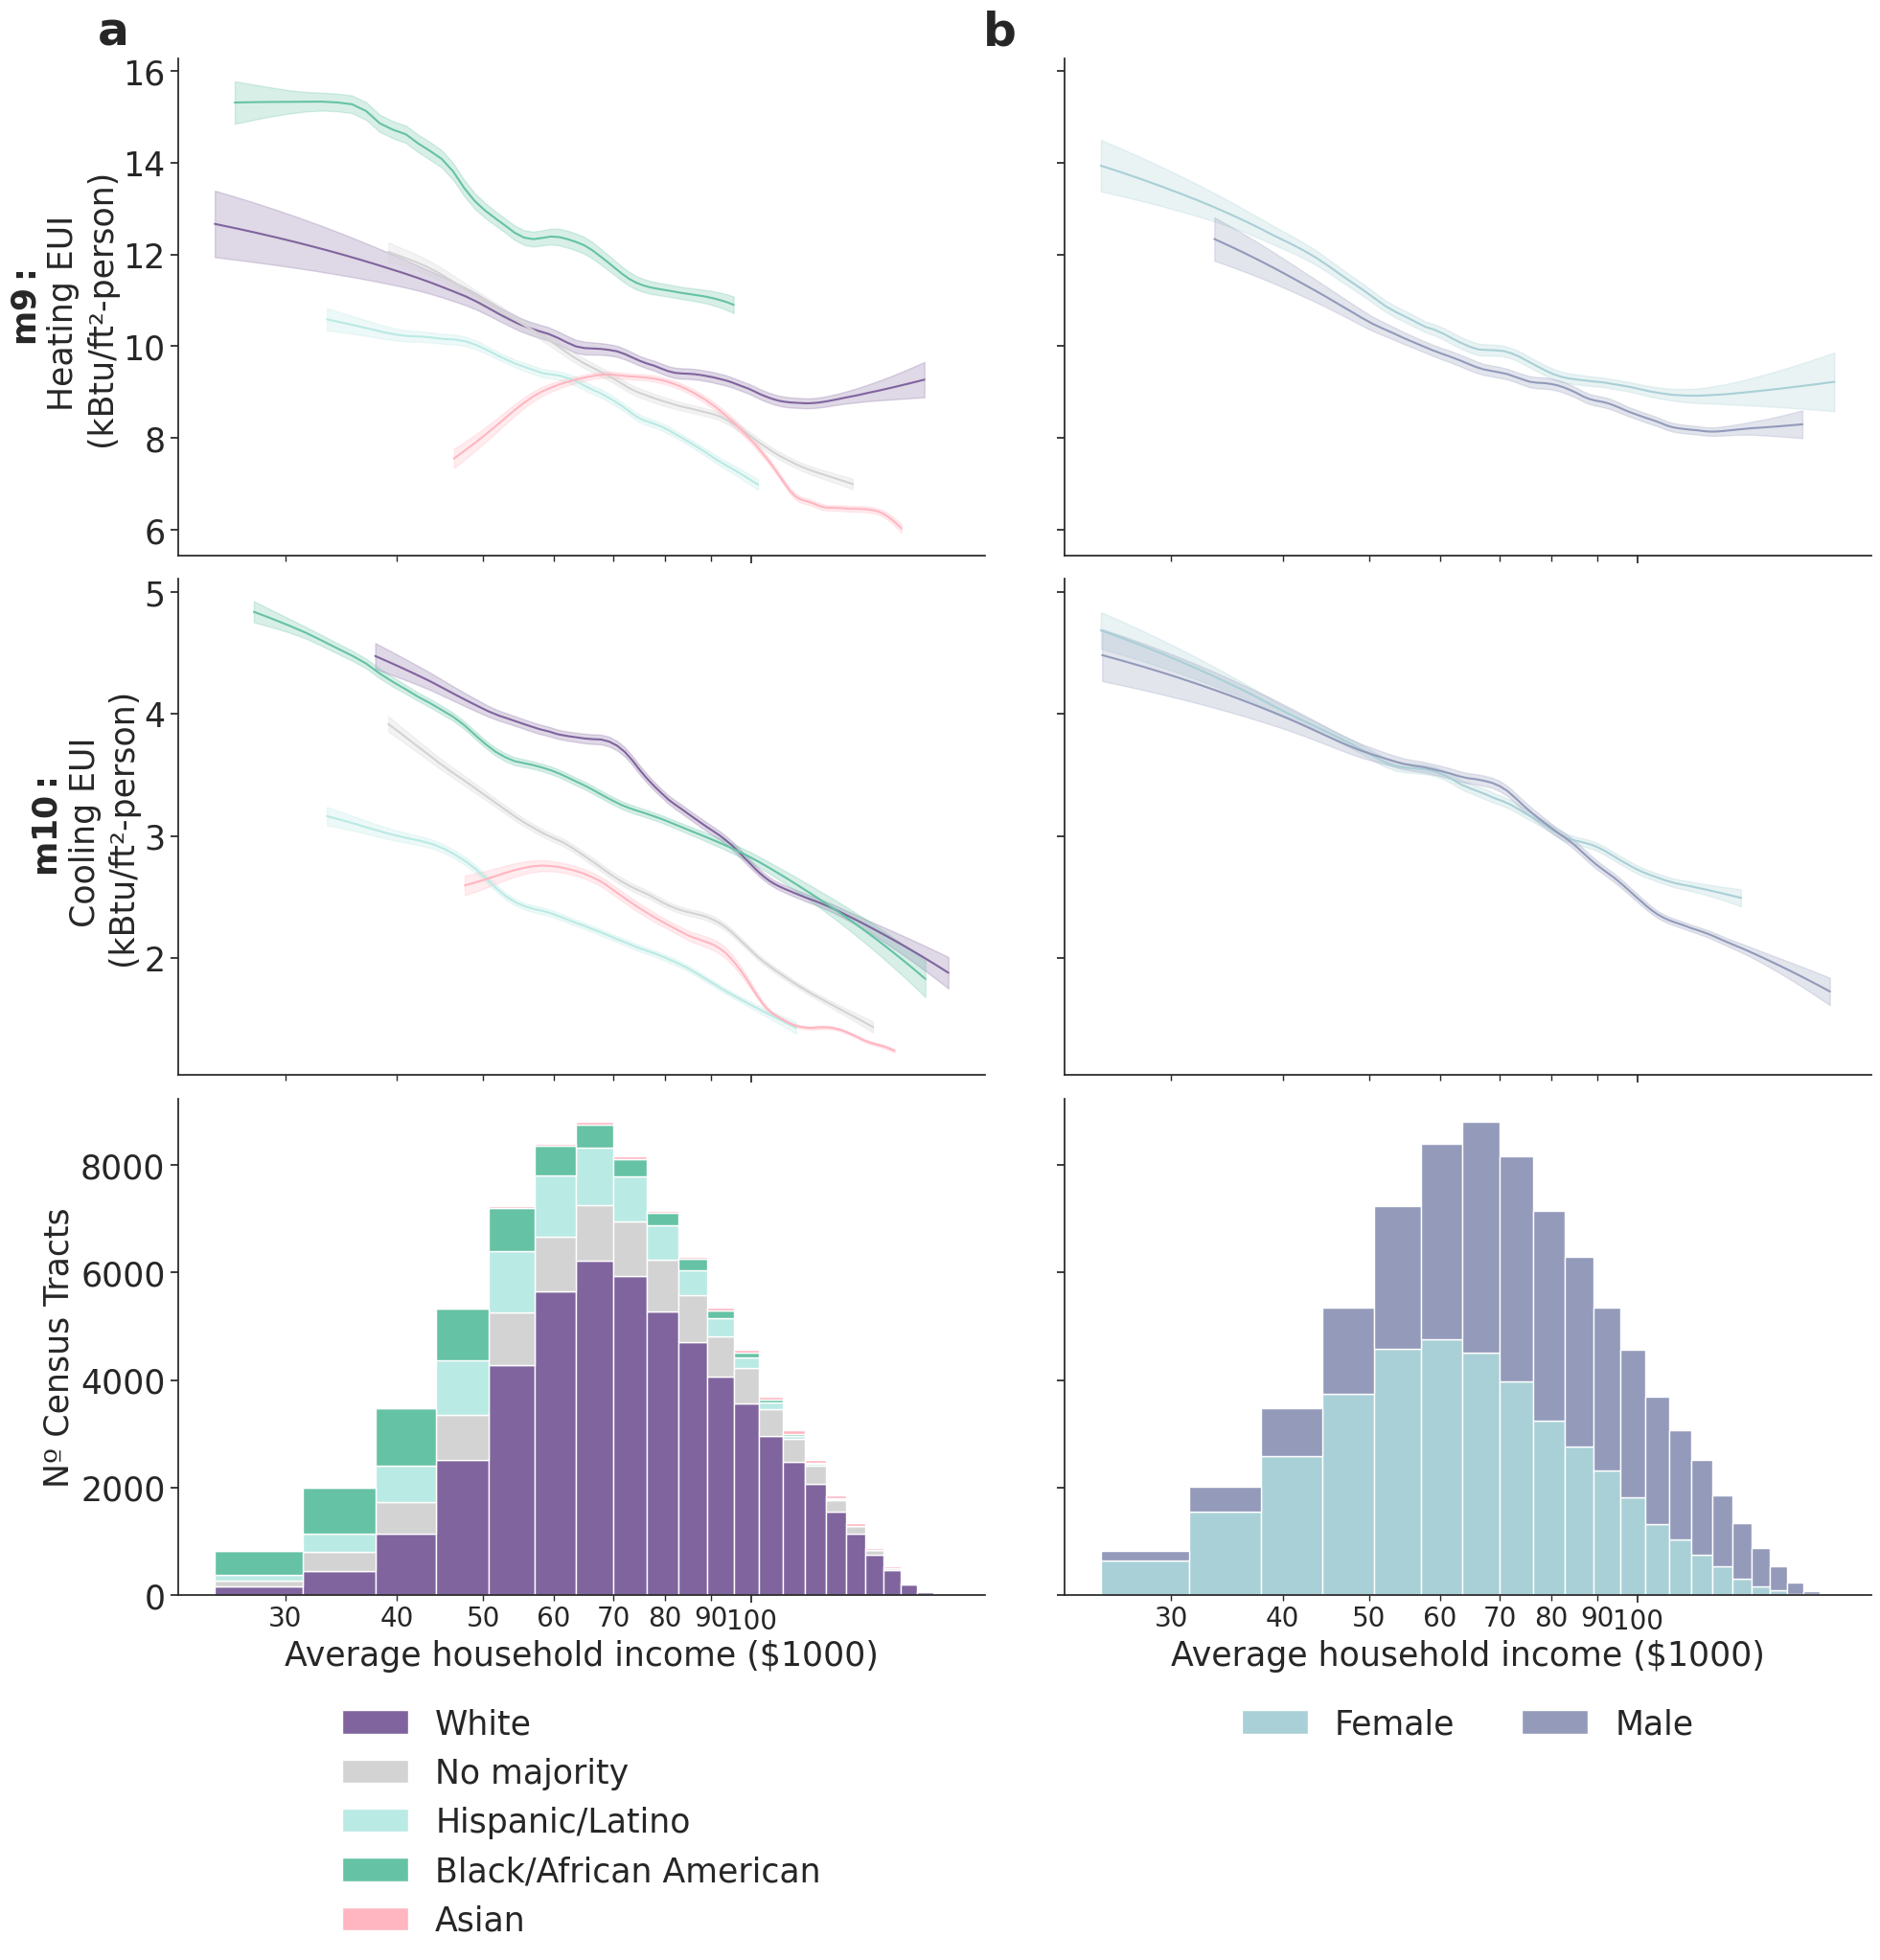

In [134]:
# Simplified race label mapping
race_label_map = {
    "Not Hispanic or Latino: White": "White",
    "No majority": "No majority",
    "Hispanic or Latino": "Hispanic/Latino",
    "Not Hispanic or Latino: Black or African American": "Black/African American",
    "Not Hispanic or Latino: Asian alone": "Asian"
}

# === Settings ===
fig, axes = plt.subplots(nrows=3, ncols=2, sharey='row', sharex=True, figsize=(20, 20))
fig.subplots_adjust(hspace=0.7)

x_variable = 'Average household income'
x_variable_new = 'Average household income_new'
acs_data_raw[x_variable_new] = acs_data_raw[x_variable].div(1000)
acs_data_raw_plot = acs_data_raw[(acs_data_raw[x_variable_new] > 25) & (acs_data_raw[x_variable_new] < 250)]

quant_indicators = ['Heating Energy Use Intensity (kBtu/ft2) \n per capita', 'Cooling Energy Use Intensity (kBtu/ft2) \n per capita', ]

demos = ['Race_majority', 'Householder_binary']
orders = [order_race, order_gender]
palettes = [palette_race, palette_gender]
cmaps = [cmap_race, cmap_gender]
fs = 25
fs_title = 30
K = 300

# === Smoothing Function ===
def smooth(x, y, xgrid, fraction, n_samples):
    samples = np.random.choice(len(x), n_samples, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s, x_s, frac=fraction, it=3, return_sorted=False)
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, fill_value='extrapolate')(xgrid)
    return y_grid

# === Plotting ===
for i, ax in enumerate(axes.flat):
    if i == 4 or i == 5:
        demo = demos[i - 4]
        cmap = cmaps[i - 4]
        order = orders[i - 4]
        palette = palettes[i - 4]

        df_pivot = acs_data_raw_plot[[x_variable_new, demo]].pivot(columns=demo, values=x_variable_new)
        df_pivot = df_pivot[order]

        labels = [race_label_map.get(d, d) for d in order] if demo == "Race_majority" else order
        ax.hist(df_pivot, bins=22, histtype='bar', stacked=True,
                color=[palette[d] for d in order], label=labels)

        ax.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=1 if i == 4 else 2, borderaxespad=0., fontsize=fs, frameon=False)
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())
        ax.set_ylabel("Nº Census Tracts", fontsize=fs)
        ax.set_xlabel("Average household income ($1000)", fontsize=fs)
        continue

    # Determine which indicator/demographic
    if i == 0:
        demo, order, palette = demos[0], orders[0], palettes[0]
        indicator = quant_indicators[0]
        ax.text(-0.1, 1.1, 'a', transform=ax.transAxes, fontsize=35, fontweight='bold', va='top', ha='left')
    elif i == 1:
        demo, order, palette = demos[1], orders[1], palettes[1]
        indicator = quant_indicators[0]
        ax.set_ylabel("")  # No y-label on second column
        ax.text(-0.1, 1.1, 'b', transform=ax.transAxes, fontsize=35, fontweight='bold', va='top', ha='left')
    elif i == 2:
        demo, order, palette = demos[0], orders[0], palettes[0]
        indicator = quant_indicators[1]
    elif i == 3:
        demo, order, palette = demos[1], orders[1], palettes[1]
        indicator = quant_indicators[1]
        ax.set_ylabel("")  # No y-label on second column

    for d in order:
        x = acs_data_raw_plot[acs_data_raw_plot[demo] == d][x_variable_new].values
        y = acs_data_raw_plot[acs_data_raw_plot[demo] == d][indicator].values

        n_samples = 100
        xgrid = np.linspace(x.min(), x.max(), n_samples)
        fraction = 0.25

        smooths = np.stack([smooth(x, y, xgrid, fraction, n_samples) for _ in range(K)]).T
        mean = np.nanmean(smooths, axis=1)
        stderr = scipy.stats.sem(smooths, axis=1, ddof=0)

        nans_idx = np.isnan(stderr)
        mean = mean[~nans_idx]
        stderr = stderr[~nans_idx]
        xgrid = xgrid[~nans_idx]

        ax.fill_between(xgrid, mean - 1.96 * stderr, mean + 1.96 * stderr, alpha=0.25, color=palette[d])
        ax.plot(xgrid, mean, color=palette[d])

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(ScalarFormatter())

    # Increase tick font sizes
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)

# === Final Labels ===
axes[0, 0].set_ylabel(r"$\mathbf{m9:}$" + "\nHeating EUI \n(kBtu/ft²-person)", fontsize=fs)
axes[1, 0].set_ylabel(r"$\mathbf{m10:}$" + "\nCooling EUI \n(kBtu/ft²-person)", fontsize=fs)
axes[2, 1].set_ylabel("")

# === Apply Large Tick Font to Last Row ===
for ax in axes[2]:
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='x', which='minor', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=25)

plt.tight_layout()
sns.despine()

In [135]:
fig.savefig("SI_eui_per_capita_rel.pdf", format="pdf", bbox_inches="tight")

##### Totals, per climate zones

In [13]:
# Define the US Census region dictionary with FIPS codes
us_census_regions = {
    'Northeast': [9, 23, 25, 33, 44, 50, 34, 36, 42],
    'Midwest': [17, 18, 26, 39, 55, 19, 20, 27, 29, 31, 38, 46],
    'South': [10, 12, 13, 24, 37, 45, 51, 11, 54, 1, 21, 28, 47, 5, 22, 40, 48],
    'West': [4, 8, 16, 30, 32, 35, 49, 56, 2, 6, 15, 41, 53]
}

# Map FIPS codes to US Census regions and add a new column
acs_data_raw['census_region'] = acs_data_raw['state'].map(
    {fips: region for region, fips_list in us_census_regions.items() for fips in fips_list}
)


0
1
2
3
4
5
6
7
8
9
10
11


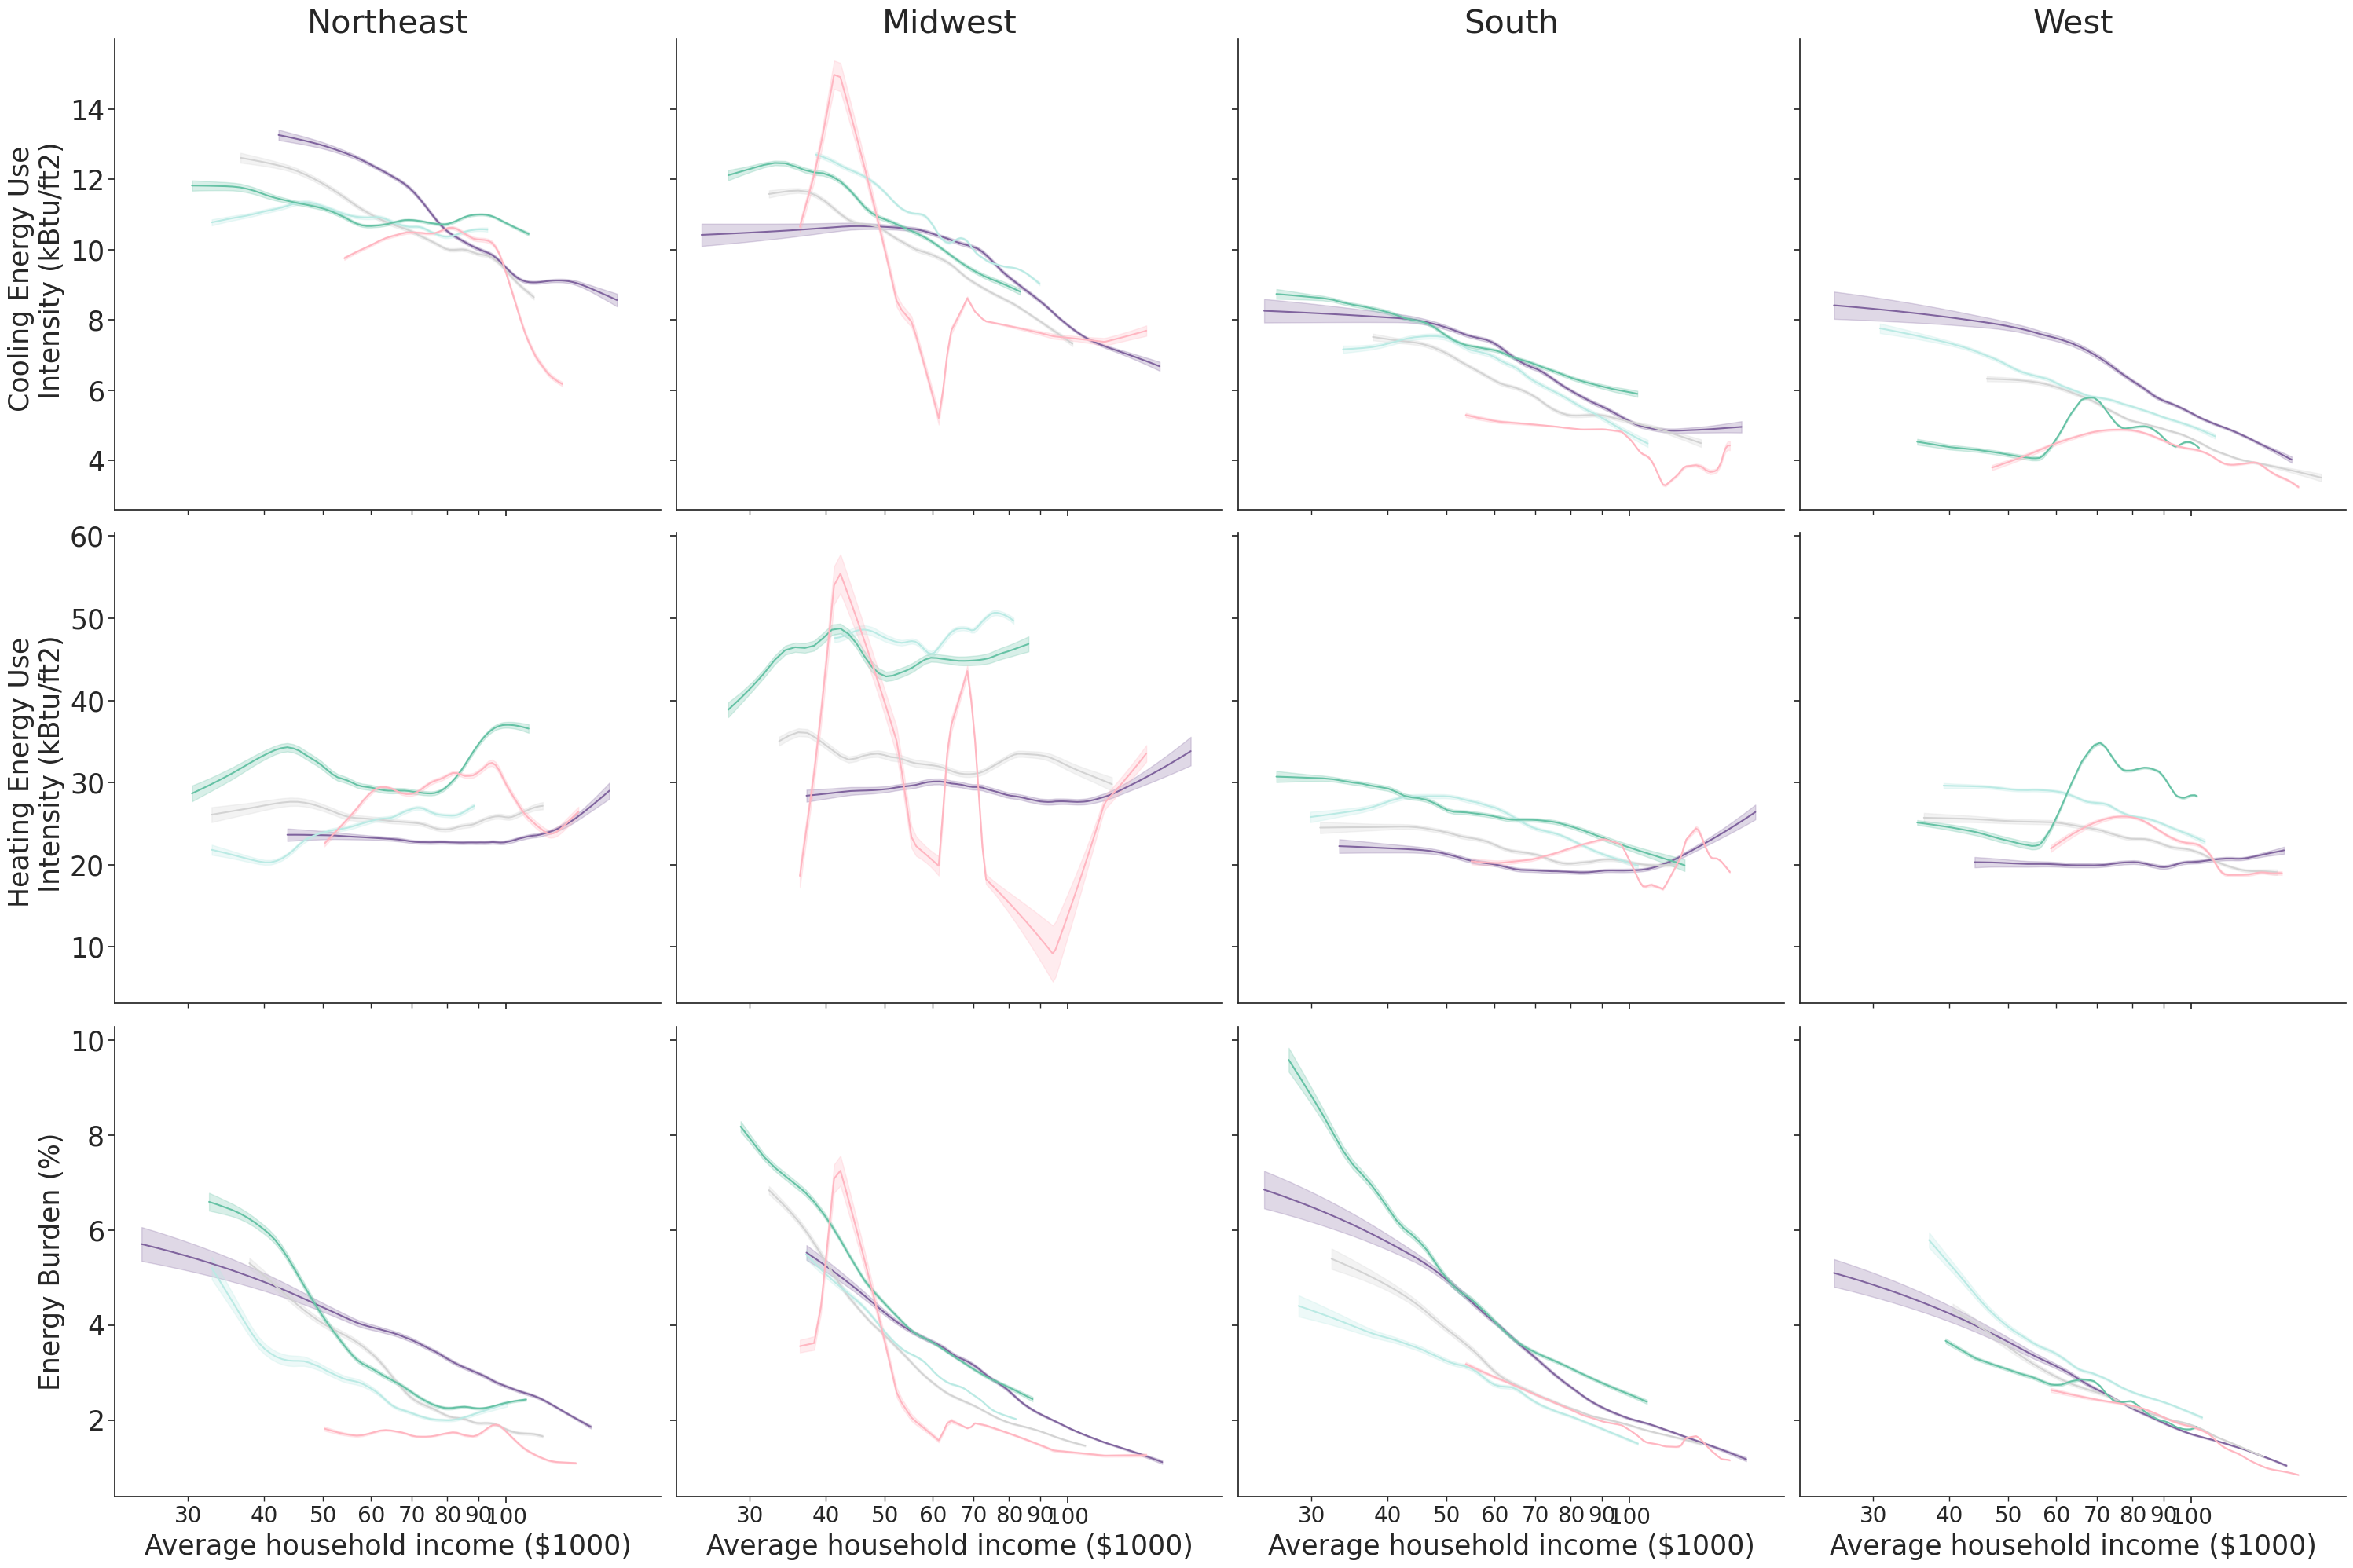

In [14]:
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 2, sharey=False, figsize=(20,20))
fig,axes=plt.subplots(nrows=3,ncols=4, sharey='row', sharex=True, figsize=(30,20))
fig.subplots_adjust(hspace=0.7)

#Control income
x_variable = 'Average household income'
x_variable_new = 'Average household income_new'
acs_data_raw[x_variable_new] = acs_data_raw[x_variable].div(1000)

#For dependency level, drop NaNs:

#frac_race = {"Hispanic or Latino":0.3 , "No majority": 0.3, "Not Hispanic or Latino: White": 0.2, "Not Hispanic or Latino: Asian alone": 0.3, "Not Hispanic or Latino: Black or African American": 0.5}
quant_indicators = ['Cooling Energy Use Intensity (kBtu/ft2)', 'Heating Energy Use Intensity (kBtu/ft2)', 'Energy Burden (%)']
#Heating Energy Use Intensity (kBtu/ft2)','Cooling Energy Use Intensity (kBtu/ft2)'

#WE WILL ONLY USE RACE HERE
demos = ['Race_majority', 'Householder_binary']
orders = [order_race, order_gender]
palettes= [palette_race, palette_gender]
cmaps = [cmap_race, cmap_gender]

regions = ['Northeast', 'Midwest', 'South', 'West',
          'Northeast', 'Midwest', 'South', 'West',
          'Northeast', 'Midwest', 'South', 'West',
          'Northeast', 'Midwest', 'South', 'West']

def smooth(x, y, xgrid, fraction, n_samples):
    
    samples = np.random.choice(len(x), n_samples, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s,x_s, frac= fraction, it=3,
                     return_sorted = False) #fraction
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

#acs_data_raw_plot = acs_data_raw[(acs_data_raw["Aggregate Household Income in the Past 12 Months"] > 25000) & (acs_data_raw["Aggregate Household Income in the Past 12 Months"] < 250000)]
acs_data_raw_plot = acs_data_raw[(acs_data_raw[x_variable_new] > 25)& (acs_data_raw[x_variable_new] < 250)]

fs =25
fs_title = 30
K = 300 #500

for i, ax in enumerate(axes.flat):
    print(i)
    
    if i == 0:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[0]
        ax.set_ylabel('Cooling Energy Use \n Intensity (kBtu/ft2)',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_title(regions[i], fontsize = fs_title)
    elif i ==1:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[0]
        ax.set_ylabel("",fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_title(regions[i], fontsize = fs_title)
    elif i ==2:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[0]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel('', fontsize = fs)
        ax.set_title(regions[i], fontsize = fs_title)
    elif i ==3:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[0]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel('', fontsize = fs)
        ax.set_title(regions[i], fontsize = fs_title)
        
    elif i ==4:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[1]
        ax.set_ylabel('Heating Energy Use \n Intensity (kBtu/ft2)',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("", fontsize = fs)
    elif i ==5:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[1]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("", fontsize = fs)
    elif i ==6:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[1]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("", fontsize = fs) 
    elif i ==7:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[1]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("", fontsize = fs)
        
    elif i ==8:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[2]
        ax.set_ylabel('Energy Burden (%)',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("Average household income ($1000)", fontsize = fs)
    elif i ==9:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[2]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("Average household income ($1000)", fontsize = fs)
    elif i ==10:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[2]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("Average household income ($1000)", fontsize = fs) 
    elif i ==11:
        demo = demos[0]
        order = orders[0]
        palette = palettes[0]
        indicator = quant_indicators[2]
        ax.set_ylabel('',fontsize=fs) #Annual Household total energy use (kBtu) #Heating Energy Use Intensity (kBtu/sq foot)
        ax.set_xlabel("Average household income ($1000)", fontsize = fs)

    for d in order:
        x = acs_data_raw_plot[(acs_data_raw['census_region']==regions[i]) & (acs_data_raw_plot[demo]==d)][x_variable_new].values
        y = acs_data_raw_plot[(acs_data_raw['census_region']==regions[i]) & (acs_data_raw_plot[demo]==d)][indicator].values
            #print(d)
            #print(len(x))

        n_samples = 100 #round(len(x)/8)
        xgrid = np.linspace(x.min(),x.max(), n_samples)
        fraction = 0.25 #frac_race[d]

        smooths = np.stack([smooth(x, y, xgrid, fraction, n_samples) for k in range(K)]).T
            #plt.plot(xgrid, smooths, color=palette_race[race], alpha=0.25) #all bootstrapped lines


        mean = np.nanmean(smooths, axis=1)
        stderr = scipy.stats.sem(smooths, axis=1, ddof=0)
            #stderr = np.nanstd(smooths, axis=1, ddof=0) this is the standard deviation

            #only plot if CI can be plotted
        nans_idx = np.isnan(stderr)
        stderr = stderr[~nans_idx ]
        mean = mean[~nans_idx ]
        xgrid = xgrid[~nans_idx]

            #weird behaviour
            #stdev = np.nanstd(smooths, axis=1, ddof=0)
            #c25 = np.nanpercentile(smooths, 5, axis=1) #2.5 percent
            #c97 = np.nanpercentile(smooths, 95, axis=1) # 97.5 percent
            #weird behaviour
            #plt.fill_between(xgrid, c25,c97, alpha=0.25, color=palette_race[demo]) #plot CI

            # plot it 
            #with 95% CI
        ax.fill_between(xgrid, mean-1.96*stderr,mean+1.96*stderr, alpha=0.25, color=palette[d]) #plot CI
        ax.plot(xgrid, mean, color=palette[d], label = d) #PLOT MEAN
            #plt.plot(x, y, 'k.') # individual points distribution
        ax.set_xscale('log')
        #ax.legend()

            #residual = (y-smooth(x,y,xgrid, fraction, n_samples))**2
            #print(sum(residual))
            #ax.legend(loc=8, borderaxespad=0.5)

    
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(ScalarFormatter())
        
    plt.setp(ax.get_yticklabels(), fontsize = fs)
    
    plt.setp(ax.get_xticklabels(),  fontsize = 20)
    plt.setp(ax.get_xticklabels(minor = True),  fontsize = 20)
    
    plt.tight_layout()
    sns.despine()
    #image_path = path +  'quant_income_analysis' + '.png'
    #plt.savefig(image_path, bbox_inches='tight')

fig.savefig("fig_4_SI_climate_zone.pdf", format="pdf", bbox_inches="tight")
